# 某闯关类手游用户流失预测

## 一、案例简介

手游在当下的日常娱乐中占据着主导性地位，成为人们生活中放松身心的一种有效途径。近年来，各种类型的手游，尤其是闯关类的休闲手游，由于其对碎片化时间的利用取得了非常广泛的市场。然而在此类手游中，新用户流失是一个非常严峻的问题，有相当多的新用户在短暂尝试后会选择放弃，而如果能在用户还没有完全卸载游戏的时候针对流失可能性较大的用户施以干预（例如奖励道具、暖心短信），就可能挽回用户从而提升游戏的活跃度和公司的潜在收益，因此用户的流失预测成为一个重要且挑战性的问题。在此项目中我们将从真实游戏中非结构化的日志数据出发，构建用户流失预测模型，综合已有知识设计适合的算法解决实际问题。

## 二、数据概览

本次使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。

对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。

本次的数据和以往结构化的形式不同，展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：

# 本次实验整体思路：  
#### 由于实验过程中很多思路，想法和代码执行顺序问题，实验报告在这里给出总结。
通过数据的观察，在特征方面做了如下尝试：   
1.将数据集中已给出的特征做一些统计上的抽取（均值，最大值，用户均值，用户最大值,...）。构造一些特征（max level id, try max,...）并以一天的时间为单位分为三段。并观察每个特征在不同label下的概率密度。   
* success_rate: 在单个用户（groupby.user_id)下的平均胜率。   
* help_rate:在单个用户（groupby.user_id)下的平均帮助使用率。   
* duration_mean:在单个用户（groupby.user_id)下的平均每局的时长。   
* reststep_mean:在单个用户（groupby.user_id)下的平均剩余步数。   
* success/duration/help/reststep_m: 整体数据集下该用户的平均情况。   
* total_help/reststep/duration, success_time: 在单个用户（groupby.user_id)下的求和。   
* try_max/try_max_lid: 玩过的局数总的最大尝试次数/最大尝试的level_id。   
* day/night/morning_duration: 按照印象中的作息以天为单位分了三个时间段的时长。   
* duration_day1234: 4天每天的时长。   
* passrate_rate: success_rate与meta_data中成功平均值的比值。   
* shdrl: 对success_rate*help_rate*duration_mean*reststep_mean的值。   

In [1422]:
print(seq_uid_df.columns)
seq_uid_df.loc[:,:'shdrl']

Index(['success_rate', 'help_rate', 'duration_mean', 'reststep_mean',
       'reststep_m', 'success_m', 'duration_m', 'help_m', 'total_help',
       'total_reststep', 'level_id_max', 'success_times', 'total_duration',
       'try_max', 'try_max_lid', 'day_duration', 'night_duration',
       'duration_day1', 'duration_day2', 'duration_day3', 'duration_day4',
       'passrate_rate', 'shdrl', 'prob_by_win_streak', 'winning_streak_mean',
       'winning_streak_mean_rate', 'duration_bias', 'help_bias',
       'reststep_bias', 'success_bias'],
      dtype='object')


,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,try_max,try_max_lid,day_duration,night_duration,duration_day1,duration_day2,duration_day3,duration_day4,passrate_rate,shdrl
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,28,91,17569.00000,11108.00000,38860.00000,38860.00000,38860.00000,38860.00000,0.59115,0.03175
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,12,146,7614.00000,7881.00000,20190.00000,20190.00000,20190.00000,20190.00000,1.15578,0.55712
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,12,111,12882.00000,2612.00000,22291.00000,22291.00000,22291.00000,22291.00000,1.36667,0.84503
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,10,51,904.00000,1123.00000,13234.00000,13234.00000,13234.00000,13234.00000,1.19606,0.70812
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,14,64,16166.00000,2285.00000,29454.00000,29454.00000,29454.00000,29454.00000,0.94338,0.51918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,19,103,4091.00000,18182.00000,27237.00000,27237.00000,27237.00000,27237.00000,1.01398,0.28561
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,10,100,18059.00000,5524.00000,38920.00000,38920.00000,38920.00000,38920.00000,1.00350,0.31191
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,3,111,1197.00000,305.00000,2195.00000,2195.00000,2195.00000,2195.00000,1.57167,17.57702


2.对每个用户每一关卡的特征展平，发现数据量太大。  
前面的特征为传统统计模型的特征，后面1509*4个特征为每个用户每个level_id的4个主要特征（success,duration,help,reststep）。  
ex:f_success_1500 为第1500关的success rate.   
由于需要两次groupby，在过程中发现pandas对groupby+apply后速度会非常的慢，有些时候for循环会更快，也可以使用modin工具的工具实现多线程工作。  

In [1093]:
print(seq_all_df.shape)
print(seq_all_df.columns[0:20])
seq_all_df

(13589, 6061)
Index(['success_rate', 'help_rate', 'duration_mean', 'reststep_mean',
       'reststep_m', 'success_m', 'duration_m', 'help_m', 'total_help',
       'total_reststep', 'level_id_max', 'success_times', 'total_duration',
       'try_max', 'try_max_lid', 'day_duration', 'night_duration',
       'duration_day1', 'duration_day2', 'duration_day3'],
      dtype='object')


,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,f_success_1500,f_success_1501,f_success_1502,f_success_1503,f_success_1504,f_success_1505,f_success_1506,f_success_1507,f_success_1508,f_success_1509
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


进而找到整体数据中主要集中的分布，观察0~200关的主要特征的均值对于label分布的情况。发现这些主要特征相乘后，lebel1的值与label0的值之比为40：160

In [1370]:
r0 = np.array(record0)
r1 = np.array(record1)
tmp = r0[:,8]<r1[:,8]
print(tmp[tmp==0].size, tmp[tmp==1].size)
tmp = r0[:,9]<r1[:,9]
print(tmp[tmp==0].size, tmp[tmp==1].size)
r0[r0==0] = 1
r1[r1==0] = 1
r0[:,8] = r0[:,1]*r0[:,2]*r0[:,3]*r0[:,4]
r1[:,8] = r1[:,1]*r1[:,2]*r1[:,3]*r1[:,4]
r0[:,9] = r0[:,1]*r0[:,3]*r0[:,4]*(r0[:,5]+r0[:,7]+r0[:,6])
r1[:,9] = r1[:,1]*r1[:,3]*r1[:,4]*(r1[:,5]+r1[:,7]+r1[:,6])
tmp = r0[:,8]<r1[:,8]
print(tmp[tmp==0].size, tmp[tmp==1].size)
tmp = r0[:,9]<r1[:,9]
print(tmp[tmp==0].size, tmp[tmp==1].size)
t0 = r0[:,1]*r0[:,2]
t1 = r1[:,1]*r1[:,2]
print(r0.shape, r1.shape)
tmp = t0 < t1
print(tmp[tmp==0].size, tmp[tmp==1].size)

t0 = r0[:,1]*r0[:,2]*r0[:,3]
t1 = r1[:,1]*r1[:,2]*r1[:,3]
print(t0.shape, t1.shape)
tmp = t0 < t1
print(tmp[tmp==0].size, tmp[tmp==1].size)

t0 = r0[:,1]*r0[:,2]*r0[:,3]*r0[:,4]
t1 = r1[:,1]*r1[:,2]*r1[:,3]*r1[:,4]
print(t0.shape, t1.shape)
tmp = t0 < t1
print(tmp[tmp==0].size, tmp[tmp==1].size)

45 155
46 154
40 160
51 149
(200, 10) (200, 10)
87 113
(200,) (200,)
63 137
(200,) (200,)
40 160


于是再将每关label0与label1的均值相加除以2，得到的这个值作为量纲，与每个用户再该关卡的值做比较，把得到比较后的值相加作为参数。   
下面duration_bias, help_bias, reststep_bias, success_bias为特征

In [1424]:
seq_uid_df[['duration_bias','help_bias','reststep_bias','success_bias']]

,duration_bias,help_bias,reststep_bias,success_bias
user_id,,,,
1,97.34136,79.57683,61.74754,86.84021
2,89.54090,196.12414,134.67864,160.64930
3,123.86106,166.27834,234.62161,194.98618
4,65.20886,75.00172,41.64725,53.76341
5,110.94253,108.91568,97.90891,106.40396
...,...,...,...,...
13585,98.36127,97.68539,112.28857,121.99076
13586,154.03771,155.81857,121.30031,158.56441
13587,14.54768,0.00000,48.99103,29.99758


3.想到每个用户连胜对结果可能有影响.  
统计了每个用户每个关卡的连胜, 将每个用户的连胜次数和连胜次数的次数做记录。  
ex: user1的连胜次数:4， user1连胜4次的次数4。
尝试了用词袋特征+伯努利的方法，效果比单用伯努利的结果要好。auc:0.67-0.70  
同样也拼接‘词袋特征’与统计特征，归一化后尝试。  

In [1425]:
seq_uwinc_df

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,430,462,473,483,524,740,843,919,1398,1675
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


对连胜特征进而提取  
用上面词袋特征+伯努利算法预测后得到的概率值，加入特征：prob_by_win_streak  
计算每个用户的连胜均值：winning_streak_mean  
观察计算不同label下的连胜均值，然后将label0和label1的连胜均值相加除以2作为量纲。  
然后将每个用户的连胜均值/量纲：winning_streak_mean_rate  
特征如下：

In [1428]:
seq_uid_df[['prob_by_win_streak','winning_streak_mean','winning_streak_mean_rate']]

,prob_by_win_streak,winning_streak_mean,winning_streak_mean_rate
user_id,,,
1,0.11339,11.16667,3.55806
2,0.02770,3.60000,1.14708
3,0.03101,3.80000,1.21080
4,0.18602,3.83333,1.22143
5,0.10079,6.57143,2.09387
...,...,...,...
13585,0.02977,4.88889,1.55776
13586,0.13492,8.71429,2.77666
13587,0.94506,1.50000,0.47795


还想到增加每局间隔的特征，但是发现存在很多duration的时间大于两局间隔的时间，目前还没有增加。
在算法上将学过的算法都有尝试。也尝试了gdbt,gdbt+lr,xgboost,lightboost。   
最后观察多模型的结果使用的多模型融合的方法，评价指标会有所提升。  
但最高的auc得分在0.74895上。  
excel记录了部分算法+特征得到的AUC。  
以上是我本次毕业设计的报告。由于相比下auc的分数并没有很高，感觉本次毕设的思路或者方向可能有些问题。

# 以下为代码部分：

### train.csv

训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。

In [1]:
import pandas as pd
import dask.dataframe as dd
import modin.pandas as mpd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as TF
from xgboost import XGBClassifier
#from tpot import TPOTClassifier
import lightgbm as lgb
import time
import datetime
from dateutil import parser
#from distributed import Client
#client = Client()
train_df = pd.read_csv('./data/train.csv', sep='\t')
#print(train_df)
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,...,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,0


In [2]:
train_df['label'].value_counts()

0    5428
1    2730
Name: label, dtype: int64

训练集共 8158 个用户，其中流失用户大约占 1/3，需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

In [2]:
pd.set_option('display.float_format',lambda x : '%.5f' % x)

### dev.csv

验证集格式和训练集相同，主要为了方便离线测试与模型选择。

In [3]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


### test.csv
测试集只包含用户 id，任务就是要预测这些用户的流失概率。

In [4]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


### level_seq.csv
这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

In [5]:
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
#type(seq_df.compute())
#seq_df = seq_df.compute()
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.00000,0.50000,0,2020-02-01 00:05:51
1,10932,2,1,69.00000,0.70370,0,2020-02-01 00:08:01
2,10932,3,1,67.00000,0.56000,0,2020-02-01 00:09:50
3,10932,4,1,58.00000,0.70000,0,2020-02-01 00:11:16
4,10932,5,1,83.00000,0.66667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.00000,0.25000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.00000,0.27778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.00000,0.00000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.00000,0.00000,0,2020-02-03 16:33:40


In [6]:
print(seq_df[(seq_df['user_id']==3) &(seq_df['level_id']==30)].mean())
seq_df[(seq_df['user_id']==3) &(seq_df['level_id']==30)]

user_id        3.00000
level_id      30.00000
f_success      0.50000
f_duration   101.50000
f_reststep     0.11364
f_help         0.00000
dtype: float64


,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
2140,3,30,0,104.00000,0.09091,0,2020-02-01 01:12:00
2141,3,30,1,99.00000,0.13636,0,2020-02-01 01:13:57


In [7]:
seq_df.groupby(['level_id']).mean()
#seq_df[(seq_df['label'] == 0) & (seq_df.user_id==20)]

,user_id,f_success,f_duration,f_reststep,f_help
level_id,,,,,
1,6811.73601,0.94229,32.95421,0.52555,0.00000
2,6785.58260,0.98671,55.38521,0.69679,0.00000
3,6779.38434,0.98530,69.98835,0.50909,0.00000
4,6797.71890,0.98999,53.67360,0.70977,0.00000
5,6780.71421,0.91310,86.09641,0.39222,0.00037
...,...,...,...,...,...
1505,10861.00000,1.00000,74.00000,0.33333,0.00000
1506,10861.00000,0.50000,97.50000,0.01852,0.00000
1507,10861.00000,0.14286,61.71429,0.01020,0.00000


将时间差分为白天:9:00-19:00，晚上：19:00-23:00,早上：23：00~9：00  
这么考虑的原因是：白天是上班时间，晚上是休息时间，早上是睡觉时间。直觉上觉得不同的时间段的区分也许能得到好的结果。                  

In [9]:
seq_df['time'] = pd.to_datetime(seq_df.time)
seq_df['day'] = seq_df['time'].dt.time.between(pd.Timestamp('09:00:00').time(), pd.Timestamp('18:59:59').time())
seq_df['night'] = seq_df['time'].dt.time.between(pd.Timestamp('19:00:00').time(), pd.Timestamp('22:59:59').time())
#seq_df['morning'] = seq_df[seq_df['day'] == seq_df['night']].time

In [8]:
all_y = pd.concat([train_df, dev_df], axis=0, ignore_index=True)
print(all_y.shape)
print(seq_df.shape)
all = pd.merge(seq_df, all_y, how='left', on='user_id' )
all = all[all.user_id>2773]
print(all.label.value_counts())
all

(10816, 2)
(2194351, 7)
0.00000    1436885
1.00000     318790
Name: label, dtype: int64


,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,label
0,10932,1,1,127.00000,0.50000,0,2020-02-01 00:05:51,0.00000
1,10932,2,1,69.00000,0.70370,0,2020-02-01 00:08:01,0.00000
2,10932,3,1,67.00000,0.56000,0,2020-02-01 00:09:50,0.00000
3,10932,4,1,58.00000,0.70000,0,2020-02-01 00:11:16,0.00000
4,10932,5,1,83.00000,0.66667,0,2020-02-01 00:13:12,0.00000
...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.00000,0.25000,1,2020-02-03 16:26:37,0.00000
2194347,10931,41,1,76.00000,0.27778,0,2020-02-03 16:28:06,0.00000
2194348,10931,42,0,121.00000,0.00000,1,2020-02-03 16:30:17,0.00000
2194349,10931,42,0,115.00000,0.00000,0,2020-02-03 16:33:40,0.00000


In [11]:
print(int(all[(all.user_id==10932)&(all.level_id==1)].f_duration))
all[(all.user_id == 10932) & (all.level_id == 1)].time + datetime.timedelta(seconds=int(all[(all.user_id==10932)&(all.level_id==1)].f_duration))

127


0   2020-02-01 00:07:58
Name: time, dtype: datetime64[ns]

In [12]:
all[all.user_id == 28]

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day,night,label


In [13]:
print(all[(all.label==0) & (all.level_id<20)].mean())
print(all[(all.label==1) & (all.level_id<20)].mean())

user_id      8143.19341
level_id       10.39633
f_success       0.90021
f_duration     81.32172
f_reststep      0.43417
f_help          0.02009
day             0.55462
night           0.26236
label           0.00000
dtype: float64
user_id      8229.75567
level_id       10.01350
f_success       0.88430
f_duration     82.20099
f_reststep      0.42909
f_help          0.02433
day             0.57210
night           0.24973
label           1.00000
dtype: float64


In [14]:
all[(all.label==1) & (all.level_id<20)].describe()

,user_id,level_id,f_success,f_duration,f_reststep,f_help,label
count,66803.00000,66803.00000,66803.00000,66803.00000,66803.00000,66803.00000,66803.00000
mean,8229.75567,10.01350,0.88430,82.20099,0.42909,0.02433,1.00000
std,3067.25053,5.51373,0.31987,50.45835,0.25535,0.15406,0.00000
min,2778.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000
25%,5664.00000,5.00000,1.00000,52.00000,0.23333,0.00000,1.00000
50%,8198.00000,10.00000,1.00000,71.00000,0.48000,0.00000,1.00000
75%,10903.00000,15.00000,1.00000,100.00000,0.62963,0.00000,1.00000
max,13588.00000,19.00000,1.00000,600.00000,1.00000,1.00000,1.00000


In [15]:
seq_df.describe()

,user_id,level_id,f_success,f_duration,f_reststep,f_help
count,2194351.00000,2194351.00000,2194351.00000,2194351.00000,2194351.00000,2194351.00000
mean,6745.03000,96.83600,0.52832,108.12279,0.16785,0.04416
std,3942.09384,84.10689,0.49920,53.61323,0.22615,0.20544
min,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000
25%,3287.00000,41.00000,0.00000,77.00000,0.00000,0.00000
50%,6688.00000,80.00000,1.00000,100.00000,0.04545,0.00000
75%,10163.00000,142.00000,1.00000,127.00000,0.28571,0.00000
max,13589.00000,1509.00000,1.00000,600.00000,1.00000,1.00000


In [9]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.88994,0.94447,35.58276,0.01723,1
1,60.68398,0.99184,56.71571,0.00464,2
2,76.94736,0.99123,71.78994,0.00448,3
3,58.17035,0.99384,54.84288,0.00476,4
4,101.78458,0.95417,85.65055,0.02735,5
...,...,...,...,...,...
1504,594.87879,0.45373,133.62500,3.18750,1505
1505,486.56250,0.45418,115.90625,3.21875,1506
1506,325.96875,0.57353,86.25000,2.68750,1507
1507,793.09677,0.32268,164.00000,5.41935,1508


In [17]:
meta_df.columns

Index(['f_avg_duration', 'f_avg_passrate', 'f_avg_win_duration',
       'f_avg_retrytimes', 'level_id'],
      dtype='object')

In [18]:
meta_df.describe()

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
count,1509.00000,1509.00000,1509.00000,1509.00000,1509.00000
mean,514.40853,0.44539,116.00910,3.42175,755.00000
std,234.73171,0.19003,27.65535,4.06888,435.75509
min,39.88994,0.00000,35.58276,0.00000,1.00000
25%,372.25000,0.33450,101.23961,2.00000,378.00000
50%,497.65217,0.40293,112.66667,3.29161,755.00000
75%,623.58706,0.50940,126.44355,4.40642,1132.00000
max,2105.00000,1.00000,540.00000,98.00000,1509.00000


发现绝大多数关卡次数都在前200关，观察每一个关卡得了label,统计每个关卡的平均胜率，平均时长，平均剩余步数，平均帮助次数，白天，晚上，早上的时长。  
最后将胜率，总时长，步数，帮助相乘得到的value。  
发现相乘后的value，留下和流失的比为40：160  

In [ ]:
record, record0, record1 = [], [], []
#for i in range(41,149):
for i in range(1,201):
    a = all[all['level_id']==i]
    a0 = all[(all['label']==0) & (all['level_id']==i)]
    a1 = all[(all['label']==1) & (all['level_id']==i)]
    aday=a[a.day==True].f_duration.mean()
    anight=a[a.night==True].f_duration.mean()
    amorning=a[a.day==a.night].f_duration.mean()
    a0day=a0[a0.day==True].f_duration.mean()
    a0night=a0[a0.night==True].f_duration.mean()
    a0morning=a0[a0.day==a0.night].f_duration.mean()
    a1day=a1[a1.day==True].f_duration.mean()
    a1night=a1[a1.night==True].f_duration.mean()
    a1morning=a1[a1.day==a1.night].f_duration.mean()
    record.append([a.level_id.count(), a.f_success.mean(), a.f_duration.mean(), a.f_reststep.mean(), a.f_help.mean(), aday,anight,amorning,(a.f_success.mean()*a.f_duration.mean()*a.f_reststep.mean()*a.f_help.mean()),(a.f_success.mean()*aday*a.f_reststep.mean()*a.f_help.mean())])
    record0.append([a0.level_id.count(), a0.f_success.mean(), a0.f_duration.mean(), a0.f_reststep.mean(), a0.f_help.mean(),a0day,a0night,a0morning,(a0.f_success.mean()*a0.f_duration.mean()*a0.f_reststep.mean()*a0.f_help.mean()),(a0.f_success.mean()*a0day*a0.f_reststep.mean()*a0.f_help.mean())])
    record1.append([a1.level_id.count(), a1.f_success.mean(), a1.f_duration.mean(), a1.f_reststep.mean(), a1.f_help.mean(),a0day,a0night,a0morning,(a1.f_success.mean()*a1.f_duration.mean()*a1.f_reststep.mean()*a1.f_help.mean()),(a1.f_success.mean()*a1day*a1.f_reststep.mean()*a1.f_help.mean())])
    print('\n')
    print('In level %d' %(i))
    print('lid count %.4f , success.mean %.4f ,duration mean %.4f, reststep.mean %.4f, help.mean %.4f,mult %.4f, multd %.4f' %(a.level_id.count(), a.f_success.mean(), a.f_duration.mean(), a.f_reststep.mean(), a.f_help.mean(),(a.f_success.mean()*a.f_duration.mean()*a.f_reststep.mean()*a.f_help.mean()),(a.f_success.mean()*aday*a.f_reststep.mean()*a.f_help.mean()))) 
    print('lid count %.4f , success.mean %.4f ,duration mean %.4f, reststep.mean %.4f, help.mean %.4f,mult %.4f, multd %.4f' %(a0.level_id.count(), a0.f_success.mean(), a0.f_duration.mean(), a0.f_reststep.mean(), a0.f_help.mean(),(a0.f_success.mean()*a0.f_duration.mean()*a0.f_reststep.mean()*a0.f_help.mean()),(a0.f_success.mean()*a0day*a0.f_reststep.mean()*a0.f_help.mean())))
    print('lid count %.4f , success.mean %.4f ,duration mean %.4f, reststep.mean %.4f, help.mean %.4f,mult %.4f, multd %.4f' %(a1.level_id.count(), a1.f_success.mean(), a1.f_duration.mean(), a1.f_reststep.mean(), a1.f_help.mean(),(a1.f_success.mean()*a1.f_duration.mean()*a1.f_reststep.mean()*a1.f_help.mean()),(a1.f_success.mean()*a1day*a1.f_reststep.mean()*a1.f_help.mean())))
    print(a.label.value_counts())
    print(a0day, a0night, a0morning, a0.f_duration.mean())

In [1370]:
r0 = np.array(record0)
r1 = np.array(record1)
tmp = r0[:,8]<r1[:,8]
print(tmp[tmp==0].size, tmp[tmp==1].size)
tmp = r0[:,9]<r1[:,9]
print(tmp[tmp==0].size, tmp[tmp==1].size)
r0[r0==0] = 1
r1[r1==0] = 1
r0[:,8] = r0[:,1]*r0[:,2]*r0[:,3]*r0[:,4]
r1[:,8] = r1[:,1]*r1[:,2]*r1[:,3]*r1[:,4]
r0[:,9] = r0[:,1]*r0[:,3]*r0[:,4]*(r0[:,5]+r0[:,7]+r0[:,6])
r1[:,9] = r1[:,1]*r1[:,3]*r1[:,4]*(r1[:,5]+r1[:,7]+r1[:,6])
tmp = r0[:,8]<r1[:,8]
print(tmp[tmp==0].size, tmp[tmp==1].size)
tmp = r0[:,9]<r1[:,9]
print(tmp[tmp==0].size, tmp[tmp==1].size)
t0 = r0[:,1]*r0[:,2]
t1 = r1[:,1]*r1[:,2]
print(r0.shape, r1.shape)
tmp = t0 < t1
print(tmp[tmp==0].size, tmp[tmp==1].size)

t0 = r0[:,1]*r0[:,2]*r0[:,3]
t1 = r1[:,1]*r1[:,2]*r1[:,3]
print(t0.shape, t1.shape)
tmp = t0 < t1
print(tmp[tmp==0].size, tmp[tmp==1].size)

t0 = r0[:,1]*r0[:,2]*r0[:,3]*r0[:,4]
t1 = r1[:,1]*r1[:,2]*r1[:,3]*r1[:,4]
print(t0.shape, t1.shape)
tmp = t0 < t1
print(tmp[tmp==0].size, tmp[tmp==1].size)

45 155
46 154
40 160
51 149
(200, 10) (200, 10)
87 113
(200,) (200,)
63 137
(200,) (200,)
40 160


观察对应关卡特征和label之间的关系

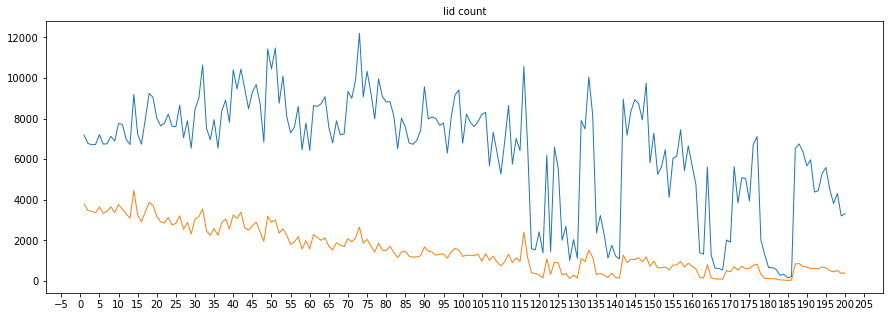

In [188]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator
y = []
for i in range(1,201):
    y.append(i)

fig = plt.figure(figsize=(15, 5))
plt.title("lid count", fontsize=10)
plt.plot(y, r0[:,0], linewidth=1,label='0')
plt.plot(y, r1[:,0], linewidth=1,label='1')
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

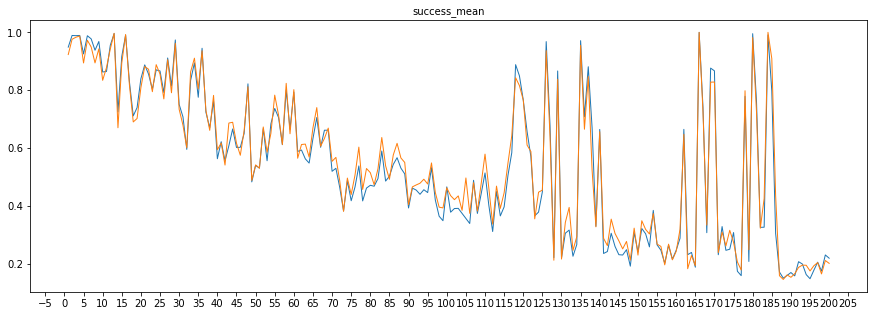

In [189]:
fig = plt.figure(figsize=(15, 5))
plt.title("success_mean", fontsize=10)
plt.plot(y, r0[:,1], linewidth=1)
plt.plot(y, r1[:,1], linewidth=1)
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

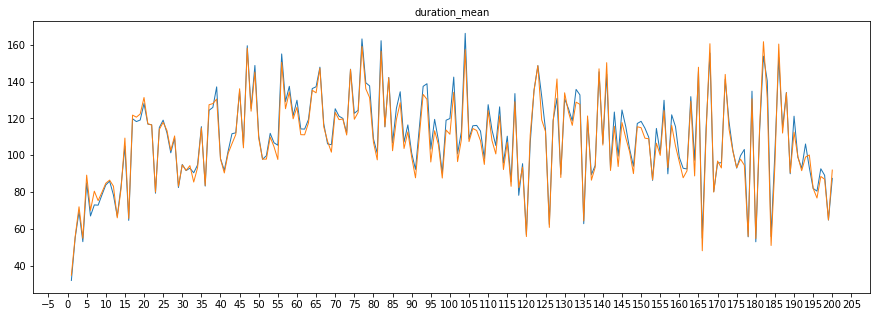

In [190]:
fig = plt.figure(figsize=(15, 5))
plt.title("duration_mean", fontsize=10)
plt.plot(y, r0[:,2], linewidth=1)
plt.plot(y, r1[:,2], linewidth=1)
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

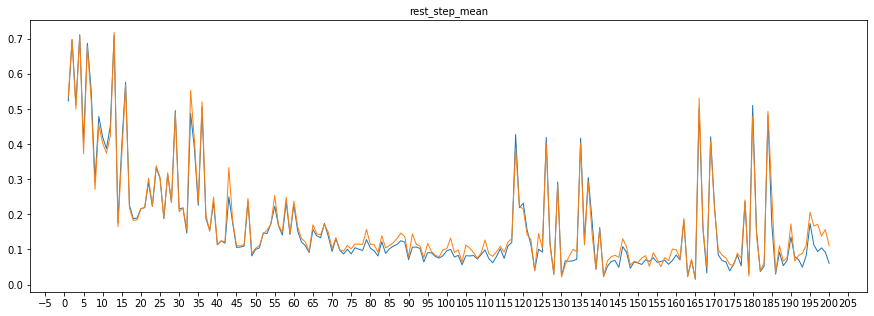

In [191]:
fig = plt.figure(figsize=(15, 5))
plt.title("rest_step_mean", fontsize=10)
plt.plot(y, r0[:,3], linewidth=1)
plt.plot(y, r1[:,3], linewidth=1)
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

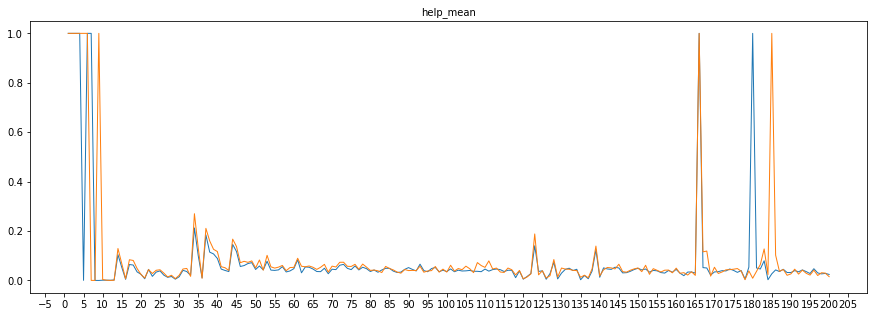

In [192]:
fig = plt.figure(figsize=(15, 5))
plt.title("help_mean", fontsize=10)
plt.plot(y, r0[:,4], linewidth=1)
plt.plot(y, r1[:,4], linewidth=1)
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

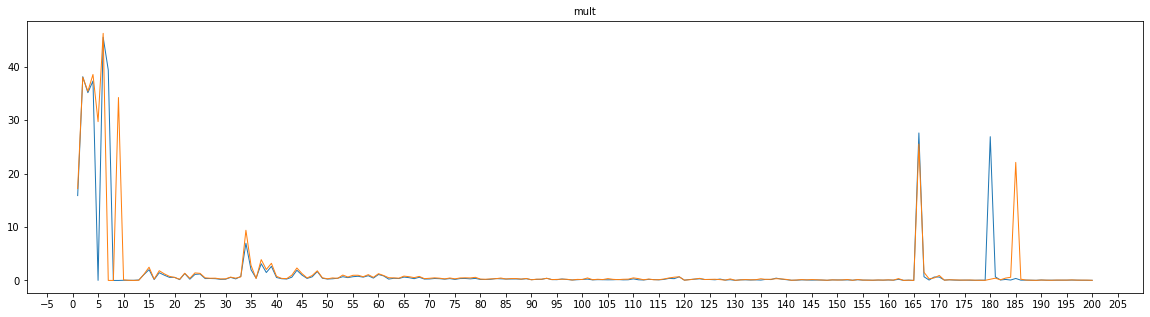

In [193]:
fig = plt.figure(figsize=(20, 5))
plt.title("mult", fontsize=10)
plt.plot(y, r0[:,1]*r0[:,2]*r0[:,3]*r0[:,4], linewidth=1)
plt.plot(y, r1[:,1]*r1[:,2]*r1[:,3]*r1[:,4], linewidth=1)
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()
#print(r0[:,5]*r1[:,5])

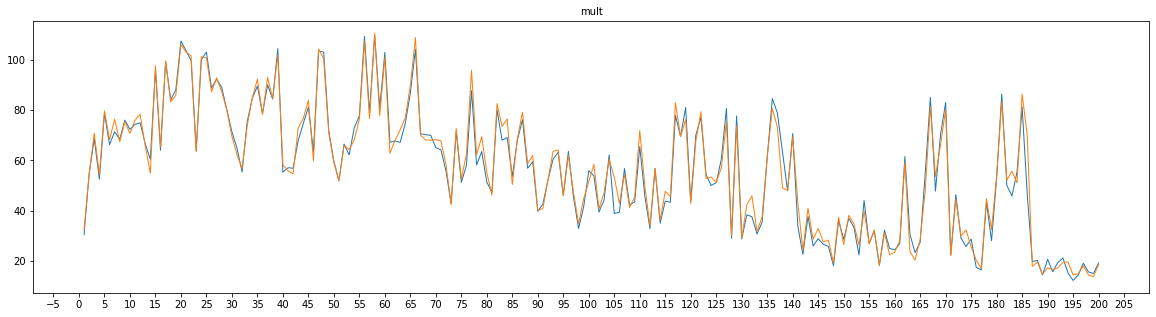

In [194]:
fig = plt.figure(figsize=(20, 5))
plt.title("mult", fontsize=10)
plt.plot(y, r0[:,1]*r0[:,2], linewidth=1)
plt.plot(y, r1[:,1]*r1[:,2], linewidth=1)
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()
#print(r0[:,1]*r0[:,2])

### level_meta.csv
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [195]:
print(seq_df.user_id.max())
seq_df

13589


,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day,night
0,10932,1,1,127.00000,0.50000,0,2020-02-01 00:05:51,False,False
1,10932,2,1,69.00000,0.70370,0,2020-02-01 00:08:01,False,False
2,10932,3,1,67.00000,0.56000,0,2020-02-01 00:09:50,False,False
3,10932,4,1,58.00000,0.70000,0,2020-02-01 00:11:16,False,False
4,10932,5,1,83.00000,0.66667,0,2020-02-01 00:13:12,False,False
...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.00000,0.25000,1,2020-02-03 16:26:37,True,False
2194347,10931,41,1,76.00000,0.27778,0,2020-02-03 16:28:06,True,False
2194348,10931,42,0,121.00000,0.00000,1,2020-02-03 16:30:17,True,False
2194349,10931,42,0,115.00000,0.00000,0,2020-02-03 16:33:40,True,False


尝试提取每局游戏的间隔特征，发现druation>每局开始时间之差。

In [196]:
seq_df[seq_df.user_id == 10932].iloc[0:30]

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day,night
0,10932,1,1,127.00000,0.50000,0,2020-02-01 00:05:51,False,False
1,10932,2,1,69.00000,0.70370,0,2020-02-01 00:08:01,False,False
2,10932,3,1,67.00000,0.56000,0,2020-02-01 00:09:50,False,False
3,10932,4,1,58.00000,0.70000,0,2020-02-01 00:11:16,False,False
4,10932,5,1,83.00000,0.66667,0,2020-02-01 00:13:12,False,False
5,10932,6,1,227.00000,0.80000,0,2020-02-01 00:17:08,False,False
6,10932,7,1,91.00000,0.53333,0,2020-02-01 01:02:30,False,False
7,10932,8,1,81.00000,0.25000,0,2020-02-01 01:04:58,False,False
8,10932,9,1,112.00000,0.46154,0,2020-02-01 01:06:52,False,False
9,10932,10,1,78.00000,0.53571,0,2020-02-01 01:10:08,False,False


考虑将每局间隔统计抽取为特征。

In [197]:
diff = []
for u in range(10932,10933):
    udur = []
    now=datetime.timedelta(seconds = 0)
    for d, t in zip(seq_df[seq_df.user_id == u].f_duration, seq_df[seq_df.user_id == u].time):
        #diff.append(t - now)
        print(t-now)
        now = t + datetime.timedelta(seconds = int(d))
            
    #diff.append(seq_df[seq_df.user_id == u].time + udur)
diff

2020-02-01 00:05:51
0 days 00:00:03
0 days 00:00:40
0 days 00:00:19
0 days 00:00:58
0 days 00:02:33
0 days 00:41:35
0 days 00:00:57
0 days 00:00:33
0 days 00:01:24
0 days 00:10:54
-1 days +23:55:46
-1 days +23:59:34
-1 days +23:59:58
0 days 00:00:35
0 days 00:00:45
0 days 00:02:50
0 days 00:05:33
-1 days +23:56:51
0 days 00:00:10
-1 days +23:59:48
0 days 00:00:26
-1 days +23:59:19
0 days 00:00:48
-1 days +23:59:22
-1 days +23:59:13
0 days 00:00:51
0 days 00:02:05
-1 days +23:58:35
-1 days +23:59:46
0 days 00:00:51
-1 days +23:58:20
0 days 00:00:41
0 days 00:00:18
-1 days +23:58:42
0 days 00:01:14
0 days 00:00:45
-1 days +23:59:17
0 days 00:08:56
0 days 00:00:22
0 days 00:01:42
0 days 00:00:06
-1 days +23:59:06
0 days 00:00:10
0 days 00:00:38
0 days 00:01:14
0 days 00:00:21
-1 days +23:59:23
-1 days +23:59:29
0 days 00:00:55
0 days 08:56:20
0 days 00:00:30
0 days 00:03:16
0 days 00:00:46
0 days 03:57:26
0 days 00:01:13
-1 days +23:58:32
-1 days +23:59:42
0 days 00:01:14
-1 days +23:59:5

[]

### 特征处理

对user_id groupby，将已有特征在user_id的基础上变换（求和，平均，融合等）。
* level_id_max（最大玩到多少关）。
* help_rate (使用帮助的概率）。
* try_max（一关最多玩了多少次）。
* try_max_lid（哪一关玩了最多）。
* success_rate（通关率）。
* success_times(成功次数）。
* f_duration_mean（每关平均时长）。
* f_reststep 代表能力。
* f_help_mean（使用帮助概率）。
* total_duration（总共玩了多久）。
* reststep/success/help/duration_m: 该用户的总数/数据集的总数
* passrate_rate （通过率与平均通过率的比值）
* shdrl 相乘
* 时间段（白天，晚上，夜晚）day/night/morning_duration 每个时间段玩了多久。
* 时间段次数 day/night/morning_count 每个时间段玩了多少次。

很多特征被注释掉是因为在消解实验中效果不好。

In [31]:
'''
seq_df['level_id_max'] = seq_uid_gb[['level_id']].transform('max')
seq_df['total_duration'] = seq_uid_gb['f_duration'].transform('sum')
print(len(seq_df))
print(seq_df.user_id.nunique())
try_max = seq_uid_gb.level_id.apply(lambda x: stats.mode(x)[1][0]).to_dict()
seq_df['try_max'] = seq_df['user_id'].map(try_max)
try_max_lid = seq_uid_gb.level_id.apply(lambda x: stats.mode(x)[0][0]).to_dict()
seq_df['try_max_lid'] = seq_df['user_id'].map(try_max_lid)
seq_df
'''
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
seq_df['time'] = pd.to_datetime(seq_df.time)
seq_df['day'] = seq_df['time'].dt.time.between(pd.Timestamp('09:00:00').time(), pd.Timestamp('18:59:59').time())
seq_df['night'] = seq_df['time'].dt.time.between(pd.Timestamp('19:00:00').time(), pd.Timestamp('22:59:59').time())
seq_df['day1'] = seq_df['time'].dt.time.between(pd.Timestamp('2020-02-01 00:00:00').time(), pd.Timestamp('2020-02-01 23:59:59').time())
seq_df['day2'] = seq_df['time'].dt.time.between(pd.Timestamp('2020-02-02 00:00:00').time(), pd.Timestamp('2020-02-02 23:59:59').time())
seq_df['day3'] = seq_df['time'].dt.time.between(pd.Timestamp('2020-02-03 00:00:00').time(), pd.Timestamp('2020-02-03 23:59:59').time())
seq_df['day4'] = seq_df['time'].dt.time.between(pd.Timestamp('2020-02-04 00:00:00').time(), pd.Timestamp('2020-02-04 23:59:59').time())
seq_uid_gb = seq_df.groupby('user_id')
success_times = seq_uid_gb.f_success.sum()
#success_time = seq_uid_gb[(seq_uid_gb['f_success'] == 1)].level_id.count()
seq_uid_df = seq_uid_gb[['f_success','f_help','f_duration','f_reststep']].mean()
seq_uid_df.rename(columns={'f_duration':'duration_mean', 'f_success':'success_rate','f_help':'help_rate','f_reststep':'reststep_mean'}, inplace=True)
seq_uid_df['reststep_m'] = seq_uid_gb.f_reststep.sum()/seq_df.f_reststep.sum()
seq_uid_df['success_m'] = seq_uid_gb.f_success.sum()/seq_df.f_success.sum()
seq_uid_df['duration_m'] = seq_uid_gb.f_duration.sum()/seq_df.f_duration.sum()
seq_uid_df['help_m'] = seq_uid_gb.f_help.sum()/seq_df.f_help.sum()
seq_uid_df['total_help'] = seq_uid_gb.f_help.sum()
seq_uid_df['total_reststep'] = seq_uid_gb.f_reststep.sum()
#seq_uid_df['len_all_time'] = seq_uid_gb.f_success.count()
seq_uid_df['level_id_max'] = seq_uid_gb.level_id.max()
seq_uid_df['success_times'] = success_times
seq_uid_df['total_duration'] = seq_uid_gb.f_duration.sum()
seq_uid_df['try_max'] = seq_uid_gb.level_id.apply(lambda x: stats.mode(x)[1][0])
seq_uid_df['try_max_lid'] = seq_uid_gb.level_id.apply(lambda x: stats.mode(x)[0][0])
seq_uid_df['day_duration'] = seq_uid_gb[['f_duration','day']].apply(lambda x: x['f_duration'][x['day']==True].sum() )
seq_uid_df['night_duration'] = seq_uid_gb[['f_duration','night']].apply(lambda x: x['f_duration'][x['night']==True].sum() )
#seq_uid_df['morning_duration'] = seq_uid_gb[['f_duration','day','night']].apply(lambda x: x['f_duration'][x['day'] == x['night']].sum() )
seq_uid_df['duration_day1'] = seq_uid_gb[['f_duration','day1']].apply(lambda x: x['f_duration'][x.day1==True].sum())
seq_uid_df['duration_day2'] = seq_uid_gb[['f_duration','day2']].apply(lambda x: x['f_duration'][x.day2==True].sum())
seq_uid_df['duration_day3'] = seq_uid_gb[['f_duration','day3']].apply(lambda x: x['f_duration'][x.day3==True].sum())
seq_uid_df['duration_day4'] = seq_uid_gb[['f_duration','day4']].apply(lambda x: x['f_duration'][x.day4==True].sum())
#seq_uid_df['day_count'] = seq_uid_gb[['f_duration','day']].apply(lambda x: x['f_duration'][x['day']==True].count() )
#seq_uid_df['night_count'] = seq_uid_gb[['f_duration','night']].apply(lambda x: x['f_duration'][x['night']==True].count() )
#seq_uid_df['morning_count'] = seq_uid_gb[['f_duration','day','night']].apply(lambda x: x['f_duration'][x['day'] == x['night']].count() )
#seq_uid_df['duration_mean_rate'] = seq_uid_df['duration_mean']/meta_df['f_avg_duration'].mean()
#seq_uid_df['passrate_rate'] = seq_uid_df['success_rate']/meta_df['f_avg_passrate'].mean()
#seq_uid_df['duration_rate'] = seq_uid_df['total_duration']/meta_df['f_avg_win_duration'].mean()
#seq_u_df_tmp = seq_uid_df.copy()
#seq_u_df_tmp[[success_rate','help_rate','reststep_mean','duration_mean]] = seq_u_df_tmp[['success_rate','help_rate','reststep_mean','duration_mean']].apply(lambda x: 1 if x==0)
#seq_uid_df['shdrl'] = seq_uid_df['success_rate'].apply(lambda x:1 if x==0 else x)*seq_uid_df['help_rate'].apply(lambda x:1 if x==0 else x)*seq_uid_df['reststep_mean'].apply(lambda x:1 if x==0 else x)*seq_uid_df['duration_mean'].apply(lambda x:1 if x==0 else x)
#seq_uid_df['level_num'] = seq_uid_gb['level_id'].nunique()
seq_uid_df

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,success_times,total_duration,try_max,try_max_lid,day_duration,night_duration,duration_day1,duration_day2,duration_day3,duration_day4
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,104,38860.00000,28,91,17569.00000,11108.00000,38860.00000,38860.00000,38860.00000,38860.00000
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,122,20190.00000,12,146,7614.00000,7881.00000,20190.00000,20190.00000,20190.00000,20190.00000
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,140,22291.00000,12,111,12882.00000,2612.00000,22291.00000,22291.00000,22291.00000,22291.00000
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,57,13234.00000,10,51,904.00000,1123.00000,13234.00000,13234.00000,13234.00000,13234.00000
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,100,29454.00000,14,64,16166.00000,2285.00000,29454.00000,29454.00000,29454.00000,29454.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,112,27237.00000,19,103,4091.00000,18182.00000,27237.00000,27237.00000,27237.00000,27237.00000
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,139,38920.00000,10,100,18059.00000,5524.00000,38920.00000,38920.00000,38920.00000,38920.00000
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,14,2195.00000,3,111,1197.00000,305.00000,2195.00000,2195.00000,2195.00000,2195.00000


In [32]:
day1_count = seq_uid_gb[['time','day1']].apply(lambda x: x['time'][x['day1']==True].count() )
day2_count = seq_uid_gb[['time','day2']].apply(lambda x: x['time'][x['day2']==True].count() )
day3_count = seq_uid_gb[['time','day3']].apply(lambda x: x['time'][x['day3']==True].count() )
day4_count = seq_uid_gb[['time','day4']].apply(lambda x: x['time'][x['day4']==True].count() )
day1_login = seq_uid_gb[['time','day1']].apply(lambda x: 1 if x['time'][x['day1']==True].count() != 0 else 0)
day2_login = seq_uid_gb[['time','day2']].apply(lambda x: 1 if x['time'][x['day2']==True].count() != 0 else 0)
day3_login = seq_uid_gb[['time','day3']].apply(lambda x: 1 if x['time'][x['day3']==True].count() != 0 else 0)
day4_login = seq_uid_gb[['time','day4']].apply(lambda x: 1 if x['time'][x['day4']==True].count() != 0 else 0)
seq_uid_df['freq'] = (day1_login+day2_login+day3_login+day4_login)/(day1_count+day2_count+day3_count+day4_count)
seq_uid_df['day1_count'] = day1_count
seq_uid_df['day2_count'] = day2_count
seq_uid_df['day3_count'] = day3_count
seq_uid_df['day4_count'] = day4_count
#seq_uid_df['day1_success_time'] = seq_uid_gb[['f_success','day1']]

seq_uid_df['day1_success_time'] = seq_uid_gb[['f_success','day1']].apply(lambda x: x['f_success'][x['day1']==True].sum())
seq_uid_df['day2_success_time'] = seq_uid_gb[['f_success','day2']].apply(lambda x: x['f_success'][x['day2']==True].sum())
seq_uid_df['day3_success_time'] = seq_uid_gb[['f_success','day3']].apply(lambda x: x['f_success'][x['day3']==True].sum())
seq_uid_df['day4_success_time'] = seq_uid_gb[['f_success','day4']].apply(lambda x: x['f_success'][x['day4']==True].sum())

seq_uid_df

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,duration_day4,freq,day1_count,day2_count,day3_count,day4_count,day1_success_time,day2_success_time,day3_success_time,day4_success_time
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,38860.00000,0.00253,395,395,395,395,104,104,104,104
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,20190.00000,0.00422,237,237,237,237,122,122,122,122
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,22291.00000,0.00435,230,230,230,230,140,140,140,140
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,13234.00000,0.00935,107,107,107,107,57,57,57,57
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,29454.00000,0.00420,238,238,238,238,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,27237.00000,0.00403,248,248,248,248,112,112,112,112
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,38920.00000,0.00322,311,311,311,311,139,139,139,139
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,2195.00000,0.05000,20,20,20,20,14,14,14,14


In [14]:
active_df = seq_uid_df.drop(columns=['day_duration','night_duration','success_rate','help_rate','duration_mean','reststep_mean','reststep_m','success_m','duration_m','help_m','total_help','total_reststep','level_id_max','success_times','total_duration','try_max','try_max_lid','shdrl','passrate_rate']).copy()
active_df

,duration_day1,duration_day2,duration_day3,duration_day4,freq,day1_count,day2_count,day3_count,day4_count,day1_success_time,day2_success_time,day3_success_time,day4_success_time
user_id,,,,,,,,,,,,,
1,38860.00000,38860.00000,38860.00000,38860.00000,0.00253,395,395,395,395,104,104,104,104
2,20190.00000,20190.00000,20190.00000,20190.00000,0.00422,237,237,237,237,122,122,122,122
3,22291.00000,22291.00000,22291.00000,22291.00000,0.00435,230,230,230,230,140,140,140,140
4,13234.00000,13234.00000,13234.00000,13234.00000,0.00935,107,107,107,107,57,57,57,57
5,29454.00000,29454.00000,29454.00000,29454.00000,0.00420,238,238,238,238,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,27237.00000,27237.00000,27237.00000,27237.00000,0.00403,248,248,248,248,112,112,112,112
13586,38920.00000,38920.00000,38920.00000,38920.00000,0.00322,311,311,311,311,139,139,139,139
13587,2195.00000,2195.00000,2195.00000,2195.00000,0.05000,20,20,20,20,14,14,14,14


In [199]:
#print(seq_uid_df[['success_rate','help_rate','help_rate','reststep_mean','duration_mean']])
print(seq_uid_df['success_rate'][seq_uid_df.success_rate==0])
seq_uid_df_tmp = seq_uid_df.copy()
seq_u_df_tmp = seq_uid_df_tmp['success_rate'].apply(lambda x:1 if x==0 else x)


user_id
1069    0.00000
2336    0.00000
3623    0.00000
4943    0.00000
5123    0.00000
5195    0.00000
7373    0.00000
8780    0.00000
9273    0.00000
9997    0.00000
11136   0.00000
11269   0.00000
11311   0.00000
11439   0.00000
12057   0.00000
12658   0.00000
Name: success_rate, dtype: float64


In [200]:
seq_uid_df

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,try_max,try_max_lid,day_duration,night_duration,duration_day1,duration_day2,duration_day3,duration_day4,passrate_rate,shdrl
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,28,91,17569.00000,11108.00000,38860.00000,38860.00000,38860.00000,38860.00000,0.59115,0.03175
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,12,146,7614.00000,7881.00000,20190.00000,20190.00000,20190.00000,20190.00000,1.15578,0.55712
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,12,111,12882.00000,2612.00000,22291.00000,22291.00000,22291.00000,22291.00000,1.36667,0.84503
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,10,51,904.00000,1123.00000,13234.00000,13234.00000,13234.00000,13234.00000,1.19606,0.70812
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,14,64,16166.00000,2285.00000,29454.00000,29454.00000,29454.00000,29454.00000,0.94338,0.51918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,19,103,4091.00000,18182.00000,27237.00000,27237.00000,27237.00000,27237.00000,1.01398,0.28561
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,10,100,18059.00000,5524.00000,38920.00000,38920.00000,38920.00000,38920.00000,1.00350,0.31191
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,3,111,1197.00000,305.00000,2195.00000,2195.00000,2195.00000,2195.00000,1.57167,17.57702


In [201]:
seq_df[seq_df.user_id ==1].f_success.reset_index(drop=True)[3]
seq_df[seq_df.user_id ==1]

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day,night,day1,day2,day3,day4
222,1,1,1,25.00000,0.50000,0,2020-02-01 00:02:07,False,False,True,True,True,True
223,1,2,1,55.00000,0.64286,0,2020-02-01 00:03:57,False,False,True,True,True,True
224,1,3,0,74.00000,0.00000,0,2020-02-01 00:05:44,False,False,True,True,True,True
225,1,3,1,82.00000,0.16000,0,2020-02-01 00:07:08,False,False,True,True,True,True
226,1,4,1,74.00000,0.46667,0,2020-02-01 00:08:24,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,1,104,0,100.00000,0.00000,0,2020-02-04 19:30:52,False,True,True,True,True,True
613,1,104,0,118.00000,0.00000,0,2020-02-04 20:45:59,False,True,True,True,True,True
614,1,104,0,122.00000,0.00000,0,2020-02-04 20:48:02,False,True,True,True,True,True
615,1,104,0,125.00000,0.00000,0,2020-02-04 20:50:08,False,True,True,True,True,True


### 增加连胜特征  
观察数据的连胜属性  
将个用户的连胜次数统计并生成词袋模型  
将连胜用统计模型（均值）

In [202]:
names = locals()
u_s = []
for u in range(1,13590):
    s0, s1, as0, as1 = {}, {}, {}, {}
    tmp = seq_df[seq_df.user_id == u].f_success.reset_index(drop=True)[0]
    r = 0
    for i in seq_df[seq_df.user_id==u].f_success:
        if i == tmp:
            r = r + 1
        else:
            names['s' + str(tmp)][r] = names['s'+str(tmp)][r] + 1 if r in names['s'+str(tmp)].keys() else 1
            r = 1
            tmp = i
    names['s' + str(tmp)][r] = names['s'+str(tmp)][r] + 1 if r in names['s'+str(tmp)].keys() else 1
    u_s.append([s0, s1])#, sum(s0.values())/len(s0), sum(s1.values())/len(s1)])

In [203]:
US = np.array(u_s)
lsm = []
print(US.shape)
np.array(list(US[0][1].values())).sum()/len(US[0][1]) 
for i in range(len(US)):
    lsm.append(0) if len(US[i][1]) == 0 else lsm.append(np.array(list(US[i][1].values())).sum()/len(US[i][1]))

(13589, 2)


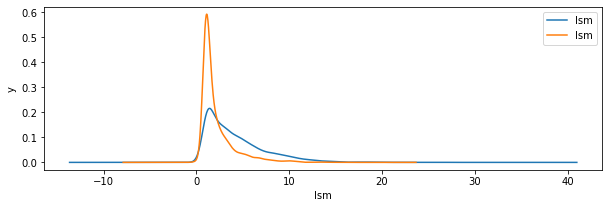

             lsm      label
count 7185.00000 7185.00000
mean     4.12593    0.00000
std      3.14490    0.00000
min      0.00000    0.00000
25%      1.66667    0.00000
50%      3.22222    0.00000
75%      5.62500    0.00000
max     27.33333    0.00000
             lsm      label
count 3631.00000 3631.00000
mean     2.15089    1.00000
std      1.83808    0.00000
min      0.00000    1.00000
25%      1.00000    1.00000
50%      1.40000    1.00000
75%      2.50000    1.00000
max     15.77778    1.00000


In [204]:
lsm_df = pd.DataFrame(lsm)
td_lsm_df = lsm_df.iloc[2773:].reset_index(drop=True)
td_lsm = pd.concat([td_lsm_df, all_y.label], axis=1)
td_lsm.columns=['lsm','label']
for i in range(2):
    td_lsm['lsm'][td_lsm['label']==i].plot.kde(figsize=(10,3),legend=True)
plt.xlabel('lsm')
plt.ylabel('y')
plt.show()
print(td_lsm[td_lsm.label==0].describe())
print(td_lsm[td_lsm.label==1].describe())

In [205]:
for i in range(len(US)):
    if US[i][1] == {}:
        print(i)

1068
2335
3622
4942
5122
5194
7372
8779
9272
9996
11135
11268
11310
11438
12056
12657


In [206]:
win_streak_cate = pd.DataFrame()
for i in range(len(US)):
    for k,v in US[i][1].items():
        win_streak_cate.loc[i,k] = v
win_streak_cate

,2,5,6,1,4,3,17,12,20,7,...,82,483,116,1398,198,178,79,144,430,77
0,16.00000,2.00000,1.00000,45.00000,2.00000,1.00000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.00000,1.00000,1.00000,13.00000,2.00000,4.00000,1.00000,1.00000,1.00000,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.00000,NaN,2.00000,13.00000,3.00000,4.00000,NaN,NaN,NaN,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.00000,1.00000,1.00000,11.00000,NaN,3.00000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.00000,4.00000,1.00000,29.00000,1.00000,3.00000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13584,11.00000,1.00000,1.00000,24.00000,2.00000,2.00000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13585,21.00000,2.00000,1.00000,32.00000,NaN,3.00000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13586,NaN,NaN,NaN,NaN,NaN,2.00000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
win_streak_cate.fillna(0, inplace=True)
win_streak_cate.sort_index(axis=1,inplace=True)
win_streak_cate.index=win_streak_cate.index+1
win_streak_cate

,1,2,3,4,5,6,7,8,9,10,...,430,462,473,483,524,740,843,919,1398,1675
1,45.00000,16.00000,1.00000,2.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,13.00000,11.00000,4.00000,2.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,13.00000,9.00000,4.00000,3.00000,0.00000,2.00000,1.00000,0.00000,1.00000,2.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,11.00000,6.00000,3.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,29.00000,7.00000,3.00000,1.00000,4.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,24.00000,11.00000,2.00000,2.00000,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,32.00000,21.00000,3.00000,0.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.00000,0.00000,2.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13588,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [208]:
win_streak_cate.index.name = 'user_id'
win_streak_cate

,1,2,3,4,5,6,7,8,9,10,...,430,462,473,483,524,740,843,919,1398,1675
user_id,,,,,,,,,,,,,,,,,,,,,
1,45.00000,16.00000,1.00000,2.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,13.00000,11.00000,4.00000,2.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,13.00000,9.00000,4.00000,3.00000,0.00000,2.00000,1.00000,0.00000,1.00000,2.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,11.00000,6.00000,3.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,29.00000,7.00000,3.00000,1.00000,4.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,24.00000,11.00000,2.00000,2.00000,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,32.00000,21.00000,3.00000,0.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.00000,0.00000,2.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [209]:
#seq_uid_df.index = seq_uid_df.index+1
seq_uid_df

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,try_max,try_max_lid,day_duration,night_duration,duration_day1,duration_day2,duration_day3,duration_day4,passrate_rate,shdrl
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,28,91,17569.00000,11108.00000,38860.00000,38860.00000,38860.00000,38860.00000,0.59115,0.03175
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,12,146,7614.00000,7881.00000,20190.00000,20190.00000,20190.00000,20190.00000,1.15578,0.55712
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,12,111,12882.00000,2612.00000,22291.00000,22291.00000,22291.00000,22291.00000,1.36667,0.84503
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,10,51,904.00000,1123.00000,13234.00000,13234.00000,13234.00000,13234.00000,1.19606,0.70812
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,14,64,16166.00000,2285.00000,29454.00000,29454.00000,29454.00000,29454.00000,0.94338,0.51918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,19,103,4091.00000,18182.00000,27237.00000,27237.00000,27237.00000,27237.00000,1.01398,0.28561
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,10,100,18059.00000,5524.00000,38920.00000,38920.00000,38920.00000,38920.00000,1.00350,0.31191
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,3,111,1197.00000,305.00000,2195.00000,2195.00000,2195.00000,2195.00000,1.57167,17.57702


In [210]:
#print(seq_uid_df)
seq_uwinc_df = pd.merge(seq_uid_df, win_streak_cate, left_index=True, right_index=True, how='left')
seq_uwinc_df.fillna(0, inplace=True)
print(seq_uwinc_df.columns[0:21])
seq_uwinc_df

Index(['success_rate', 'help_rate', 'duration_mean', 'reststep_mean',
       'reststep_m', 'success_m', 'duration_m', 'help_m', 'total_help',
       'total_reststep', 'level_id_max', 'success_times', 'total_duration',
       'try_max', 'try_max_lid', 'day_duration', 'night_duration',
       'duration_day1', 'duration_day2', 'duration_day3', 'duration_day4'],
      dtype='object')


,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,430,462,473,483,524,740,843,919,1398,1675
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


尝试用词袋模型 + 伯努利模型  
结果分数确实比单用伯努利的方式要高

In [211]:
win_streak_cate = seq_uwinc_df.drop(columns = ['success_rate', 'help_rate', 'duration_mean', 'reststep_mean',
       'reststep_m', 'success_m', 'duration_m', 'help_m', 'total_help',
       'total_reststep', 'level_id_max', 'success_times', 'total_duration',
       'try_max', 'try_max_lid', 'day_duration', 'night_duration',
       'duration_day1', 'duration_day2', 'duration_day3', 'duration_day4','shdrl','passrate_rate'])
win_streak_cate

,1,2,3,4,5,6,7,8,9,10,...,430,462,473,483,524,740,843,919,1398,1675
user_id,,,,,,,,,,,,,,,,,,,,,
1,45.00000,16.00000,1.00000,2.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,13.00000,11.00000,4.00000,2.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,13.00000,9.00000,4.00000,3.00000,0.00000,2.00000,1.00000,0.00000,1.00000,2.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,11.00000,6.00000,3.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,29.00000,7.00000,3.00000,1.00000,4.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,24.00000,11.00000,2.00000,2.00000,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,32.00000,21.00000,3.00000,0.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.00000,0.00000,2.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [213]:
pd.set_option("display.max_info_columns", 200) 

In [938]:
df = win_streak_cate
#print(df)
print(df.shape)
#print(train_df.shape)
#print(train_df.user_id)
#print(dev_df.shape)
#print(dev_df.user_id)
#print(test_df.shape)
#df = seq_all_df
#print(df)
train_df_x = df.loc[train_df['user_id'].values]
#print(train_df_x)
#print(df)
dev_df_x = df.loc[dev_df['user_id'].values]
test_df_x = df.loc[test_df['user_id'].values]
train_df_x
train_y = train_df.label.values
dev_y = dev_df.label.values
train_x = train_df_x.values
dev_x = dev_df_x.values
test_x = test_df_x.values
train_x.shape, dev_x.shape, test_x.shape, train_y.shape, dev_y.shape

(13589, 160)


((8158, 160), (2658, 160), (2773, 160), (8158,), (2658,))

In [939]:
BNB = BernoulliNB()
BNB.fit(train_x,train_y)
pred_train_y = BNB.predict(train_x)
pred_dev_y = BNB.predict(dev_x)
prob_dev_y = BNB.predict_proba(dev_x)
verify_acc = accuracy_score(pred_dev_y, dev_y)
train_acc = accuracy_score(pred_train_y, train_y)
print("Accuracy train by BernoulliNB is : %.6f" %(train_acc))
print("Accuracy verify by BernoulliNB is : %.6f" %(verify_acc))
print("The AUC by BernoulliNB of verify is %.6f" %(roc_auc_score(dev_y, prob_dev_y[:,1])))
prob_test_y = BNB.predict_proba(test_x)
prob_train_y = BNB.predict_proba(train_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
bnb_df = pd.DataFrame(result, columns=['user_id','proba'])
bnb_df.to_csv('./result.csv', sep=',', header=True, index=False)
print(prob_train_y[:,1])
print(prob_train_y[:,1].shape, prob_dev_y[:,1].shape, prob_test_y[:,1].shape)
prob = BNB.predict_proba(df.values)
print(prob[:,1].shape)

Accuracy train by BernoulliNB is : 0.712797
Accuracy verify by BernoulliNB is : 0.712942
The AUC by BernoulliNB of verify is 0.717672
[0.0342405  0.04041828 0.14539399 ... 0.21426061 0.96438311 0.57940375]
(8158,) (2658,) (2773,)
(13589,)


In [1380]:
seq_uid_df['prob_by_win_streak'] = prob[:,1]
seq_uid_df

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,try_max_lid,day_duration,night_duration,duration_day1,duration_day2,duration_day3,duration_day4,passrate_rate,shdrl,prob_by_win_streak
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,91,17569.00000,11108.00000,38860.00000,38860.00000,38860.00000,38860.00000,0.59115,0.03175,0.11339
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,146,7614.00000,7881.00000,20190.00000,20190.00000,20190.00000,20190.00000,1.15578,0.55712,0.02770
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,111,12882.00000,2612.00000,22291.00000,22291.00000,22291.00000,22291.00000,1.36667,0.84503,0.03101
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,51,904.00000,1123.00000,13234.00000,13234.00000,13234.00000,13234.00000,1.19606,0.70812,0.18602
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,64,16166.00000,2285.00000,29454.00000,29454.00000,29454.00000,29454.00000,0.94338,0.51918,0.10079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,103,4091.00000,18182.00000,27237.00000,27237.00000,27237.00000,27237.00000,1.01398,0.28561,0.02977
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,100,18059.00000,5524.00000,38920.00000,38920.00000,38920.00000,38920.00000,1.00350,0.31191,0.13492
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,111,1197.00000,305.00000,2195.00000,2195.00000,2195.00000,2195.00000,1.57167,17.57702,0.94506


In [ ]:
#pd.options.display.max_info_columns = 200
#seq_uwinc_df.info(verbose=True)

In [722]:
#ttt = seq_uwinc_df.isnull().any(axis=1)
#ttt[ttt==True]

user_id
1069     True
2336     True
3623     True
4943     True
5123     True
5195     True
7373     True
8780     True
9273     True
9997     True
11136    True
11269    True
11311    True
11439    True
12057    True
12658    True
dtype: bool

In [ ]:
#for i in seq_uwinc_df.loc[1069]:
#    print(i)

In [214]:
lsm = np.array(lsm)
print(lsm.shape)
seq_uid_df['winning_streak_mean'] = lsm
seq_uid_df['winning_streak_mean_rate'] = lsm/((4.12593+2.15089)/2)
seq_uid_df

(13589,)


,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,day_duration,night_duration,duration_day1,duration_day2,duration_day3,duration_day4,passrate_rate,shdrl,winning_streak_mean,winning_streak_mean_rate
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,17569.00000,11108.00000,38860.00000,38860.00000,38860.00000,38860.00000,0.59115,0.03175,11.16667,3.55806
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,7614.00000,7881.00000,20190.00000,20190.00000,20190.00000,20190.00000,1.15578,0.55712,3.60000,1.14708
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,12882.00000,2612.00000,22291.00000,22291.00000,22291.00000,22291.00000,1.36667,0.84503,3.80000,1.21080
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,904.00000,1123.00000,13234.00000,13234.00000,13234.00000,13234.00000,1.19606,0.70812,3.83333,1.22143
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,16166.00000,2285.00000,29454.00000,29454.00000,29454.00000,29454.00000,0.94338,0.51918,6.57143,2.09387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,4091.00000,18182.00000,27237.00000,27237.00000,27237.00000,27237.00000,1.01398,0.28561,4.88889,1.55776
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,18059.00000,5524.00000,38920.00000,38920.00000,38920.00000,38920.00000,1.00350,0.31191,8.71429,2.77666
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,1197.00000,305.00000,2195.00000,2195.00000,2195.00000,2195.00000,1.57167,17.57702,1.50000,0.47795


In [215]:
seq_uid_df[np.isinf(seq_uid_df.values)]

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,day_duration,night_duration,duration_day1,duration_day2,duration_day3,duration_day4,passrate_rate,shdrl,winning_streak_mean,winning_streak_mean_rate
user_id,,,,,,,,,,,,,,,,,,,,,


In [135]:
'''
fig = plt.figure(figsize=(20, 5))
plt.title('lsm', fontsize=10)
plt.plot(kind='kde', lsm0, linewidth=1)
plt.plot(kind='kde', lsm1, linewidth=1)
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

for i in range(2):
    
    lsm[all[all.label==i].user_id.values-1].plot.kde(figsize=(6,2),legend=True)
    #X['success_rate'][X['label']==i].plot.kde(figsize=(6,2),legend=True)
plt.xlabel('lsm')
plt.ylabel('y')
plt.show()

fig = plt.figure(figsize=(20, 5))
plt.title("mult", fontsize=10)
plt.plot(y, r0[:,1]*r0[:,2], linewidth=1)
plt.plot(y, r1[:,1]*r1[:,2], linewidth=1)
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()
'''

'\nfig = plt.figure(figsize=(20, 5))\nplt.title(\'lsm\', fontsize=10)\nplt.plot(kind=\'kde\', lsm0, linewidth=1)\nplt.plot(kind=\'kde\', lsm1, linewidth=1)\nx_major_locator=MultipleLocator(5)\nax=plt.gca()\nax.xaxis.set_major_locator(x_major_locator)\nplt.show()\n\nfor i in range(2):\n    \n    lsm[all[all.label==i].user_id.values-1].plot.kde(figsize=(6,2),legend=True)\n    #X[\'success_rate\'][X[\'label\']==i].plot.kde(figsize=(6,2),legend=True)\nplt.xlabel(\'lsm\')\nplt.ylabel(\'y\')\nplt.show()\n\nfig = plt.figure(figsize=(20, 5))\nplt.title("mult", fontsize=10)\nplt.plot(y, r0[:,1]*r0[:,2], linewidth=1)\nplt.plot(y, r1[:,1]*r1[:,2], linewidth=1)\nx_major_locator=MultipleLocator(5)\nax=plt.gca()\nax.xaxis.set_major_locator(x_major_locator)\nplt.show()\n'

In [216]:
print(seq_df[seq_df.user_id == 1069 ].f_success.reset_index(drop=True))
#seq_df[seq_df.user_id == 1069].f_success.reset_index(drop=True)[0]

0    0
1    0
Name: f_success, dtype: int64


### 查看构造的特征之间的相关性

将每一关的信息融入数据集，每个用户的每一关的特征排开，特征数会比较多，一个用户除了总的特征外，每一关的特征也会拍平列出

In [217]:
seq_df['time'] = pd.to_datetime(seq_df.time)
seq_df['day'] = seq_df['time'].dt.time.between(pd.Timestamp('09:00:00').time(), pd.Timestamp('18:59:59').time())
seq_df['night'] = seq_df['time'].dt.time.between(pd.Timestamp('19:00:00').time(), pd.Timestamp('22:59:59').time())
seq_ulid_gb = seq_df.groupby(['user_id','level_id'])

In [218]:
start =time.clock()
l_success_times = seq_ulid_gb.f_success.sum()
seq_ulid_df = seq_ulid_gb[['f_success','f_help','f_duration','f_reststep']].mean()
#seq_ulid_df.rename(columns={'f_duration':'l_duration_mean', 'f_success':'l_success_rate','f_help':'l_help_rate','f_reststep':'reststep_rate'},inplace=True)
#print(seq_ulid_df.columns)
#seq_ulid_df['shdr'] = seq_ulid_df['l_success_rate']*seq_ulid_df['l_help_rate']*seq_ulid_df['l_duration_mean']*seq_ulid_df['reststep_rate']
#seq_ulid_df['l_success_times'] = l_success_times
#seq_ulid_df['l_duration'] = seq_ulid_gb['f_duration'].sum()
#seq_ulid_df['l_day_duration'] = seq_ulid_gb[['f_duration','day']].apply(lambda x: x['f_duration'][x['day']==True].sum())
#seq_ulid_df['l_night_duration'] = seq_ulid_gb[['f_duration', 'night']].apply(lambda x: x['f_duration'][x['night']==True].sum())
#seq_ulid_df['l_morning_duration'] = seq_ulid_gb[['f_duration','day','night']].apply(lambda x: x['f_duration'][(x.day==False) & (x.night==False)].sum())

end = time.clock()
print('Running time: %s Seconds'%(end-start))
seq_ulid_df

Running time: 1.0049363999860361 Seconds


f_success  f_help  f_duration  f_reststep
user_id level_id                                           
1       1           1.00000 0.00000    25.00000     0.50000
        2           1.00000 0.00000    55.00000     0.64286
        3           0.50000 0.00000    78.00000     0.08000
        4           1.00000 0.00000    74.00000     0.46667
        5           1.00000 0.00000    79.00000     0.29167
...                     ...     ...         ...         ...
13589   15          1.00000 0.00000    71.00000     0.54286
        16          1.00000 0.00000    51.00000     0.50000
        17          1.00000 0.00000   107.00000     0.03125
        18          1.00000 0.00000    80.00000     0.36667
        19          0.00000 0.00000   102.00000     0.00000

[1130659 rows x 4 columns]

In [219]:
seq_ulid_df.to_csv('./seq_ulid_df.csv')

In [220]:
#seq_uidlid_df = seq_ulid_df.pivot_table( index=['user_id'], columns=['level_id'], values = ['f_success','f_help','f_duration','l_success_times','l_duration','l_day_duration','l_night_duration','l_morning_duration'])
seq_uidlid_df = seq_ulid_df.pivot_table( index=['user_id'], columns=['level_id'], values = ['f_success','f_help','f_duration','f_reststep'])
print(seq_uidlid_df.columns)
seq_uidlid_df

MultiIndex([('f_duration',    1),
            ('f_duration',    2),
            ('f_duration',    3),
            ('f_duration',    4),
            ('f_duration',    5),
            ('f_duration',    6),
            ('f_duration',    7),
            ('f_duration',    8),
            ('f_duration',    9),
            ('f_duration',   10),
            ...
            ( 'f_success', 1500),
            ( 'f_success', 1501),
            ( 'f_success', 1502),
            ( 'f_success', 1503),
            ( 'f_success', 1504),
            ( 'f_success', 1505),
            ( 'f_success', 1506),
            ( 'f_success', 1507),
            ( 'f_success', 1508),
            ( 'f_success', 1509)],
           names=[None, 'level_id'], length=6036)


f_duration                                                         \
level_id       1        2        3        4         5        6        7      
user_id                                                                      
1          25.00000 55.00000 78.00000 74.00000  79.00000 50.00000 64.00000   
2          21.00000 32.00000 34.00000 24.00000  70.00000 37.00000 30.00000   
3          24.00000 35.00000 47.00000 41.00000  78.00000 49.00000 62.00000   
4          25.00000 39.00000 61.00000 51.00000  70.00000 83.00000 44.00000   
5          30.00000 72.00000 89.00000 51.00000  97.00000 79.00000 69.00000   
...             ...      ...      ...      ...       ...      ...      ...   
13585      28.00000 42.00000 66.00000 32.00000 115.00000 34.00000 60.00000   
13586      26.00000 71.00000 76.00000 56.00000  93.00000 81.00000 86.00000   
13587           NaN      NaN      NaN      NaN       NaN      NaN      NaN   
13588      18.00000 55.00000 66.00000 55.00000  60.00000 65.00000 44.00000   
13589      13.00000 45.00000 53.00000 36.00000  52.00000 87.00000      NaN   

                                      ... f_success                           \
level_id      8        9        10    ...      1500 1501 1502 1503 1504 1505   
user_id                               ...                                      
1         63.50000 66.00000 63.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   
2         38.00000 34.00000 38.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   
3         56.00000 58.00000 50.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   
4        180.00000 97.00000 91.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   
5         86.00000 80.00000 78.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   
...            ...      ...      ...  ...       ...  ...  ...  ...  ...  ...   
13585     57.00000 52.00000 53.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   
13586     81.00000 85.00000 74.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   
13587          NaN      NaN      NaN  ...       NaN  NaN  NaN  NaN  NaN  NaN   
13588     46.00000 60.00000 82.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   
13589     52.00000 73.00000 53.00000  ...       NaN  NaN  NaN  NaN  NaN  NaN   

                              
level_id 1506 1507 1508 1509  
user_id                       
1         NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  
...       ...  ...  ...  ...  
13585     NaN  NaN  NaN  NaN  
13586     NaN  NaN  NaN  NaN  
13587     NaN  NaN  NaN  NaN  
13588     NaN  NaN  NaN  NaN  
13589     NaN  NaN  NaN  NaN  

[13589 rows x 6036 columns]

In [221]:
col = [c1 + '_' + str(c2) for (c1, c2) in seq_uidlid_df.columns.to_list() ]
col
seq_uidlid_df.columns = col
seq_uidlid_df

,f_duration_1,f_duration_2,f_duration_3,f_duration_4,f_duration_5,f_duration_6,f_duration_7,f_duration_8,f_duration_9,f_duration_10,...,f_success_1500,f_success_1501,f_success_1502,f_success_1503,f_success_1504,f_success_1505,f_success_1506,f_success_1507,f_success_1508,f_success_1509
user_id,,,,,,,,,,,,,,,,,,,,,
1,25.00000,55.00000,78.00000,74.00000,79.00000,50.00000,64.00000,63.50000,66.00000,63.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21.00000,32.00000,34.00000,24.00000,70.00000,37.00000,30.00000,38.00000,34.00000,38.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24.00000,35.00000,47.00000,41.00000,78.00000,49.00000,62.00000,56.00000,58.00000,50.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25.00000,39.00000,61.00000,51.00000,70.00000,83.00000,44.00000,180.00000,97.00000,91.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,30.00000,72.00000,89.00000,51.00000,97.00000,79.00000,69.00000,86.00000,80.00000,78.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,28.00000,42.00000,66.00000,32.00000,115.00000,34.00000,60.00000,57.00000,52.00000,53.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13586,26.00000,71.00000,76.00000,56.00000,93.00000,81.00000,86.00000,81.00000,85.00000,74.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
seq_uidlid_df.fillna(0,inplace=True)
seq_uidlid_df

,f_duration_1,f_duration_2,f_duration_3,f_duration_4,f_duration_5,f_duration_6,f_duration_7,f_duration_8,f_duration_9,f_duration_10,...,f_success_1500,f_success_1501,f_success_1502,f_success_1503,f_success_1504,f_success_1505,f_success_1506,f_success_1507,f_success_1508,f_success_1509
user_id,,,,,,,,,,,,,,,,,,,,,
1,25.00000,55.00000,78.00000,74.00000,79.00000,50.00000,64.00000,63.50000,66.00000,63.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,21.00000,32.00000,34.00000,24.00000,70.00000,37.00000,30.00000,38.00000,34.00000,38.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,24.00000,35.00000,47.00000,41.00000,78.00000,49.00000,62.00000,56.00000,58.00000,50.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,25.00000,39.00000,61.00000,51.00000,70.00000,83.00000,44.00000,180.00000,97.00000,91.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,30.00000,72.00000,89.00000,51.00000,97.00000,79.00000,69.00000,86.00000,80.00000,78.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,28.00000,42.00000,66.00000,32.00000,115.00000,34.00000,60.00000,57.00000,52.00000,53.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,26.00000,71.00000,76.00000,56.00000,93.00000,81.00000,86.00000,81.00000,85.00000,74.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [143]:
seq_uidlid_df.to_csv('./seq_uidlid_df.csv')

In [144]:
seq_uidlid_df = pd.read_csv('./seq_uidlid_df.csv')
seq_uidlid_df

,user_id,f_duration_1,f_duration_2,f_duration_3,f_duration_4,f_duration_5,f_duration_6,f_duration_7,f_duration_8,f_duration_9,...,f_success_1500,f_success_1501,f_success_1502,f_success_1503,f_success_1504,f_success_1505,f_success_1506,f_success_1507,f_success_1508,f_success_1509
0,1,25.00000,55.00000,78.00000,74.00000,79.00000,50.00000,64.00000,63.50000,66.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,2,21.00000,32.00000,34.00000,24.00000,70.00000,37.00000,30.00000,38.00000,34.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,3,24.00000,35.00000,47.00000,41.00000,78.00000,49.00000,62.00000,56.00000,58.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,4,25.00000,39.00000,61.00000,51.00000,70.00000,83.00000,44.00000,180.00000,97.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,5,30.00000,72.00000,89.00000,51.00000,97.00000,79.00000,69.00000,86.00000,80.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13584,13585,28.00000,42.00000,66.00000,32.00000,115.00000,34.00000,60.00000,57.00000,52.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13585,13586,26.00000,71.00000,76.00000,56.00000,93.00000,81.00000,86.00000,81.00000,85.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,13587,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,13588,18.00000,55.00000,66.00000,55.00000,60.00000,65.00000,44.00000,46.00000,60.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [223]:
seq_uid_df

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,day_duration,night_duration,duration_day1,duration_day2,duration_day3,duration_day4,passrate_rate,shdrl,winning_streak_mean,winning_streak_mean_rate
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,17569.00000,11108.00000,38860.00000,38860.00000,38860.00000,38860.00000,0.59115,0.03175,11.16667,3.55806
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,7614.00000,7881.00000,20190.00000,20190.00000,20190.00000,20190.00000,1.15578,0.55712,3.60000,1.14708
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,12882.00000,2612.00000,22291.00000,22291.00000,22291.00000,22291.00000,1.36667,0.84503,3.80000,1.21080
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,904.00000,1123.00000,13234.00000,13234.00000,13234.00000,13234.00000,1.19606,0.70812,3.83333,1.22143
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,16166.00000,2285.00000,29454.00000,29454.00000,29454.00000,29454.00000,0.94338,0.51918,6.57143,2.09387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,4091.00000,18182.00000,27237.00000,27237.00000,27237.00000,27237.00000,1.01398,0.28561,4.88889,1.55776
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,18059.00000,5524.00000,38920.00000,38920.00000,38920.00000,38920.00000,1.00350,0.31191,8.71429,2.77666
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,1197.00000,305.00000,2195.00000,2195.00000,2195.00000,2195.00000,1.57167,17.57702,1.50000,0.47795


In [224]:
# combine uidlid uid
seq_all_df = pd.concat([seq_uid_df, seq_uidlid_df], axis=1)
print(seq_all_df.shape)
print(seq_all_df.columns[0:20])
seq_all_df

(13589, 6061)
Index(['success_rate', 'help_rate', 'duration_mean', 'reststep_mean',
       'reststep_m', 'success_m', 'duration_m', 'help_m', 'total_help',
       'total_reststep', 'level_id_max', 'success_times', 'total_duration',
       'try_max', 'try_max_lid', 'day_duration', 'night_duration',
       'duration_day1', 'duration_day2', 'duration_day3'],
      dtype='object')


,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,f_success_1500,f_success_1501,f_success_1502,f_success_1503,f_success_1504,f_success_1505,f_success_1506,f_success_1507,f_success_1508,f_success_1509
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


对每个用户每一关的特征精细化比较  
记录每一关卡0和1的特征指标，计算每一个关卡0和1指标的平均（不是全局平均），将用户玩过的关卡的均值与该关卡的均值做比较，再加权。  
加权的方法可以通过求和来观察。
观察用户玩过的关卡的序列的指标（差或者比）

In [234]:
all

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day,night,label
0,10932,1,1,127.00000,0.50000,0,2020-02-01 00:05:51,False,False,0.00000
1,10932,2,1,69.00000,0.70370,0,2020-02-01 00:08:01,False,False,0.00000
2,10932,3,1,67.00000,0.56000,0,2020-02-01 00:09:50,False,False,0.00000
3,10932,4,1,58.00000,0.70000,0,2020-02-01 00:11:16,False,False,0.00000
4,10932,5,1,83.00000,0.66667,0,2020-02-01 00:13:12,False,False,0.00000
...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.00000,0.25000,1,2020-02-03 16:26:37,True,False,0.00000
2194347,10931,41,1,76.00000,0.27778,0,2020-02-03 16:28:06,True,False,0.00000
2194348,10931,42,0,121.00000,0.00000,1,2020-02-03 16:30:17,True,False,0.00000
2194349,10931,42,0,115.00000,0.00000,0,2020-02-03 16:33:40,True,False,0.00000


In [235]:
#print(all)
all0, all1 = [], []
for i in range(1,1510):
    all0.append(all[(all.label==0) & (all.level_id==i)][['f_success','f_duration','f_reststep','f_help','day','night']].mean())
    all1.append(all[(all.label==1) & (all.level_id==i)][['f_success','f_duration','f_reststep','f_help','day','night']].mean())

In [236]:
all0 = np.array(all0)
all1 = np.array(all1)
print(all0.shape, all1.shape)
all0, all1
all0_df = pd.DataFrame(all0, columns=['f_success','f_duration','f_reststep','f_help','day','night'])
all1_df = pd.DataFrame(all1, columns=['f_success','f_duration','f_reststep','f_help','day','night'])
all0_df_f0 = all0_df.fillna(0)
all1_df_f0 = all1_df.fillna(0)
scalar = (all0_df_f0 + all1_df_f0)/2
scalar.index = scalar.index+1
scalar

(1509, 6) (1509, 6)


,f_success,f_duration,f_reststep,f_help,day,night
1,0.93609,33.45661,0.52830,0.00000,0.57498,0.25296
2,0.98266,55.58162,0.69706,0.00000,0.57016,0.25207
3,0.98580,70.73566,0.50581,0.00000,0.56608,0.25618
4,0.98840,54.00693,0.71058,0.00000,0.56600,0.25396
5,0.90976,87.12970,0.38591,0.00028,0.56439,0.25483
...,...,...,...,...,...,...
1505,0.50000,37.00000,0.16667,0.00000,0.50000,0.00000
1506,0.25000,48.75000,0.00926,0.00000,0.50000,0.00000
1507,0.07143,30.85714,0.00510,0.00000,0.50000,0.00000
1508,0.25000,45.50000,0.02885,0.00000,0.50000,0.00000


In [228]:
seq_uidlid_df

,f_duration_1,f_duration_2,f_duration_3,f_duration_4,f_duration_5,f_duration_6,f_duration_7,f_duration_8,f_duration_9,f_duration_10,...,f_success_1500,f_success_1501,f_success_1502,f_success_1503,f_success_1504,f_success_1505,f_success_1506,f_success_1507,f_success_1508,f_success_1509
user_id,,,,,,,,,,,,,,,,,,,,,
1,25.00000,55.00000,78.00000,74.00000,79.00000,50.00000,64.00000,63.50000,66.00000,63.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,21.00000,32.00000,34.00000,24.00000,70.00000,37.00000,30.00000,38.00000,34.00000,38.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,24.00000,35.00000,47.00000,41.00000,78.00000,49.00000,62.00000,56.00000,58.00000,50.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,25.00000,39.00000,61.00000,51.00000,70.00000,83.00000,44.00000,180.00000,97.00000,91.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,30.00000,72.00000,89.00000,51.00000,97.00000,79.00000,69.00000,86.00000,80.00000,78.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,28.00000,42.00000,66.00000,32.00000,115.00000,34.00000,60.00000,57.00000,52.00000,53.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13586,26.00000,71.00000,76.00000,56.00000,93.00000,81.00000,86.00000,81.00000,85.00000,74.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13587,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [229]:
 # duration, help, reststep, success
tmp = np.hstack((scalar.f_duration.values , scalar.f_help.values , scalar.f_reststep.values , scalar.f_success.values))
seq_uidlid_df.columns
tmp.shape
seq_uid_lid_df = seq_uidlid_df / tmp
seq_uid_lid_df.fillna(0, inplace=True)
seq_uid_lid_df[np.isinf(seq_uid_lid_df.values)] = 0
duration_bias = seq_uid_lid_df.iloc[:,0:1509].sum(axis=1)
help_bias = seq_uid_lid_df.iloc[:,1509:1509*2].sum(axis=1)
reststep_bias = seq_uid_lid_df.iloc[:,1509*2:1509*3].sum(axis=1)
success_bias = seq_uid_lid_df.iloc[:,1509*3:1509*4].sum(axis=1)
duration_bias, help_bias, reststep_bias, success_bias

seq_uid_df['duration_bias'] = duration_bias
seq_uid_df['help_bias'] = help_bias
seq_uid_df['reststep_bias'] = reststep_bias
seq_uid_df['success_bias'] = success_bias


In [230]:
seq_uid_df.iloc[:,26:][np.isinf(seq_uid_df.iloc[:,26:])]
#seq_uid_df[np.isinf(seq_uid_df.values)].any()
seq_uid_lid_df[np.isinf(seq_uid_lid_df.values)] 
seq_uid_df


,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,duration_day3,duration_day4,passrate_rate,shdrl,winning_streak_mean,winning_streak_mean_rate,duration_bias,help_bias,reststep_bias,success_bias
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.26329,0.02025,98.37975,0.06053,0.00006,0.00009,0.00016,0.00008,8,23.90768,...,38860.00000,38860.00000,0.59115,0.03175,11.16667,3.55806,97.34136,79.57683,61.74754,86.84021
2,0.51477,0.08439,85.18987,0.15055,0.00010,0.00011,0.00009,0.00021,20,35.67952,...,20190.00000,20190.00000,1.15578,0.55712,3.60000,1.14708,89.54090,196.12414,134.67864,160.64930
3,0.60870,0.06087,96.91739,0.23532,0.00015,0.00012,0.00009,0.00014,14,54.12474,...,22291.00000,22291.00000,1.36667,0.84503,3.80000,1.21080,123.86106,166.27834,234.62161,194.98618
4,0.53271,0.07477,123.68224,0.14375,0.00004,0.00005,0.00006,0.00008,8,15.38100,...,13234.00000,13234.00000,1.19606,0.70812,3.83333,1.22143,65.20886,75.00172,41.64725,53.76341
5,0.42017,0.08403,123.75630,0.11882,0.00008,0.00009,0.00012,0.00021,20,28.27816,...,29454.00000,29454.00000,0.94338,0.51918,6.57143,2.09387,110.94253,108.91568,97.90891,106.40396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,0.45161,0.04839,109.82661,0.11901,0.00008,0.00010,0.00011,0.00012,12,29.51388,...,27237.00000,27237.00000,1.01398,0.28561,4.88889,1.55776,98.36127,97.68539,112.28857,121.99076
13586,0.44695,0.05145,125.14469,0.10839,0.00009,0.00012,0.00016,0.00017,16,33.70994,...,38920.00000,38920.00000,1.00350,0.31191,8.71429,2.77666,154.03771,155.81857,121.30031,158.56441
13587,0.70000,0.00000,109.75000,0.22879,0.00001,0.00001,0.00001,0.00000,0,4.57586,...,2195.00000,2195.00000,1.57167,17.57702,1.50000,0.47795,14.54768,0.00000,48.99103,29.99758


In [238]:
seq_ulid_gb = seq_df.groupby(['user_id','level_id'])
start =time.clock()
l_success_times = seq_ulid_gb.f_success.sum()
seq_ul_df = seq_ulid_gb[['f_success','f_help','f_duration']].mean()
seq_ul_df.rename(columns={'f_duration':'l_duration_mean', 'f_success':'l_success_rate','f_help':'l_help_rate'},inplace=True)
#seq_ul_df['l_success_times'] = l_success_times
#seq_ul_df['l_duration'] = seq_ulid_gb['f_duration'].sum()
#seq_ul_df['l_day_duration'] = seq_ulid_gb[['f_duration','day']].apply(lambda x: x['f_duration'][x['day']==True].sum())
#seq_ul_df['l_night_duration'] = seq_ulid_gb[['f_duration', 'night']].apply(lambda x: x['f_duration'][x['night']==True].sum())
#seq_ul_df['l_morning_duration'] = seq_ulid_gb[['f_duration','day','night']].apply(lambda x: x['f_duration'][(x.day==False) & (x.night==False)].sum())

end = time.clock()
print('Running time: %s Seconds'%(end-start))
seq_ulid_df

Running time: 0.7860646999906749 Seconds


f_success  f_help  f_duration  f_reststep
user_id level_id                                           
1       1           1.00000 0.00000    25.00000     0.50000
        2           1.00000 0.00000    55.00000     0.64286
        3           0.50000 0.00000    78.00000     0.08000
        4           1.00000 0.00000    74.00000     0.46667
        5           1.00000 0.00000    79.00000     0.29167
...                     ...     ...         ...         ...
13589   15          1.00000 0.00000    71.00000     0.54286
        16          1.00000 0.00000    51.00000     0.50000
        17          1.00000 0.00000   107.00000     0.03125
        18          1.00000 0.00000    80.00000     0.36667
        19          0.00000 0.00000   102.00000     0.00000

[1130659 rows x 4 columns]

In [237]:
(all[all.label==0].groupby('level_id').mean() + all[all.label==1].groupby('level_id').mean())

,user_id,f_success,f_duration,f_reststep,f_help,day,night,label
level_id,,,,,,,,
1,16410.71575,1.87219,66.91321,1.05661,0.00000,1.14995,0.50592,1.00000
2,16334.81904,1.96531,111.16324,1.39412,0.00000,1.14031,0.50414,1.00000
3,16401.45649,1.97161,141.47133,1.01163,0.00000,1.13216,0.51235,1.00000
4,16399.93850,1.97680,108.01387,1.42116,0.00000,1.13201,0.50791,1.00000
5,16372.65969,1.81952,174.25939,0.77183,0.00055,1.12878,0.50965,1.00000
...,...,...,...,...,...,...,...,...
1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


划分训练集，验证集，测试集

In [239]:
seq_uwinc_df.columns[0:30]
df = seq_uwinc_df.drop(columns=['passrate_rate'])
print(df.columns[0:30])
seq_uid_df.shape

Index([  'success_rate',      'help_rate',  'duration_mean',  'reststep_mean',
           'reststep_m',      'success_m',     'duration_m',         'help_m',
           'total_help', 'total_reststep',   'level_id_max',  'success_times',
       'total_duration',        'try_max',    'try_max_lid',   'day_duration',
       'night_duration',  'duration_day1',  'duration_day2',  'duration_day3',
        'duration_day4',          'shdrl',                1,                2,
                      3,                4,                5,                6,
                      7,                8],
      dtype='object')


(13589, 29)

In [241]:
seq_uid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13589 entries, 1 to 13589
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   success_rate              13589 non-null  float64
 1   help_rate                 13589 non-null  float64
 2   duration_mean             13589 non-null  float64
 3   reststep_mean             13589 non-null  float64
 4   reststep_m                13589 non-null  float64
 5   success_m                 13589 non-null  float64
 6   duration_m                13589 non-null  float64
 7   help_m                    13589 non-null  float64
 8   total_help                13589 non-null  int64  
 9   total_reststep            13589 non-null  float64
 10  level_id_max              13589 non-null  int64  
 11  success_times             13589 non-null  int64  
 12  total_duration            13589 non-null  float64
 13  try_max                   13589 non-null  int64  
 14  try_ma

In [243]:
seq_cut_df = seq_uid_df.copy()
for c in seq_cut_df.columns:
    if seq_cut_df[c].nunique() > 40:
        seq_cut_df[c] = pd.qcut(seq_cut_df[c],q=40,labels = False, duplicates='drop')
seq_cut_df

,success_rate,help_rate,duration_mean,reststep_mean,reststep_m,success_m,duration_m,help_m,total_help,total_reststep,...,duration_day3,duration_day4,passrate_rate,shdrl,winning_streak_mean,winning_streak_mean_rate,duration_bias,help_bias,reststep_bias,success_bias
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,4,15,0,21,26,35,7,7,21,...,35,35,0,0,32,32,25,18,16,20
2,9,27,7,9,31,30,27,17,17,31,...,27,27,9,14,19,19,24,29,29,30
3,15,21,14,21,37,32,28,13,13,37,...,28,28,15,19,19,19,30,27,37,33
4,10,25,31,8,12,15,21,7,7,12,...,21,21,10,17,19,19,18,18,12,14
5,4,27,31,5,25,25,32,17,17,25,...,32,32,4,14,27,27,28,22,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,5,17,23,5,27,28,31,11,11,27,...,31,31,5,8,23,23,26,21,25,25
13586,5,18,32,3,30,32,35,15,15,30,...,35,35,5,9,30,30,35,27,27,30
13587,21,0,23,21,1,3,5,0,0,1,...,5,5,21,33,5,5,2,0,13,8


In [45]:
#seq_uid_df.drop(columns = ['winning_streak_mean_rate'], inplace=True)
print(seq_uid_df.columns)
print(seq_uid_df.shape)
df = seq_uid_df
#df = seq_cut_df
#df = active_df
#df = seq_uwinc_df
#df = win_streak_cate
print(df.shape)
#df = seq_all_df
#print(df)
train_df_x = df.loc[train_df['user_id'].values]
dev_df_x = df.loc[dev_df['user_id'].values]
test_df_x = df.loc[test_df['user_id'].values]
train_df_x
train_y = train_df.label.values
dev_y = dev_df.label.values
train_x = train_df_x.values
dev_x = dev_df_x.values
test_x = test_df_x.values
print(train_x.shape, dev_x.shape, test_x.shape, train_y.shape, dev_y.shape)
train_x = np.vstack((train_x, dev_x))
train_y = np.vstack((train_y.reshape(-1,1), dev_y.reshape(-1,1))).reshape(-1)
train_x.shape, train_y.shape

Index(['success_rate', 'help_rate', 'duration_mean', 'reststep_mean',
       'reststep_m', 'success_m', 'duration_m', 'help_m', 'total_help',
       'total_reststep', 'level_id_max', 'success_times', 'total_duration',
       'try_max', 'try_max_lid', 'day_duration', 'night_duration',
       'duration_day1', 'duration_day2', 'duration_day3', 'duration_day4',
       'freq', 'day1_count', 'day2_count', 'day3_count', 'day4_count',
       'day1_success_time', 'day2_success_time', 'day3_success_time',
       'day4_success_time'],
      dtype='object')
(13589, 30)
(13589, 30)
(8158, 30) (2658, 30) (2773, 30) (8158,) (2658,)


((10816, 30), (10816,))

归一化

In [34]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(train_x)
train_x = mm_scaler.transform(train_x)
test_x = mm_scaler.transform(test_x)
print(train_x.shape, test_x.shape)

#seq_uid_df[['duration_mean','level_id_max','total_duration','try_max','try_max_lid','day_duration','night_duration','morning_duration','day_count','night_count','morning_count']]
#print(seq_uid_df.iloc[:,2:].values)
'''
df = seq_uwinc_df
scaler = MinMaxScaler()
scaler.fit(df.iloc[:,2:].values)
train_x = scaler.transform(train_df_x.iloc[:,2:].values)
dev_x = scaler.transform(dev_df_x.iloc[:,2:].values)
test_x = scaler.transform(test_df_x.iloc[:,2:].values)
train_x = np.hstack((train_df_x.iloc[:,[0,1]].values,train_x))
dev_x = np.hstack((dev_df_x.iloc[:,[0,1]].values,dev_x))
test_x = np.hstack((test_df_x.iloc[:,[0,1]].values,test_x))
train_y = train_df.label.values
dev_y = dev_df.label.values
train_x.shape, dev_x.shape, test_x.shape, train_y.shape, dev_y.shape
train_x = np.vstack((train_x, dev_x))
train_y = np.vstack((train_y.reshape(-1,1), dev_y.reshape(-1,1))).reshape(-1)
train_x.shape, train_y.shape
'''

(10816, 30) (2773, 30)


'\ndf = seq_uwinc_df\nscaler = MinMaxScaler()\nscaler.fit(df.iloc[:,2:].values)\ntrain_x = scaler.transform(train_df_x.iloc[:,2:].values)\ndev_x = scaler.transform(dev_df_x.iloc[:,2:].values)\ntest_x = scaler.transform(test_df_x.iloc[:,2:].values)\ntrain_x = np.hstack((train_df_x.iloc[:,[0,1]].values,train_x))\ndev_x = np.hstack((dev_df_x.iloc[:,[0,1]].values,dev_x))\ntest_x = np.hstack((test_df_x.iloc[:,[0,1]].values,test_x))\ntrain_y = train_df.label.values\ndev_y = dev_df.label.values\ntrain_x.shape, dev_x.shape, test_x.shape, train_y.shape, dev_y.shape\ntrain_x = np.vstack((train_x, dev_x))\ntrain_y = np.vstack((train_y.reshape(-1,1), dev_y.reshape(-1,1))).reshape(-1)\ntrain_x.shape, train_y.shape\n'

Text(0.5, 1.0, 'distribution of help_rate')

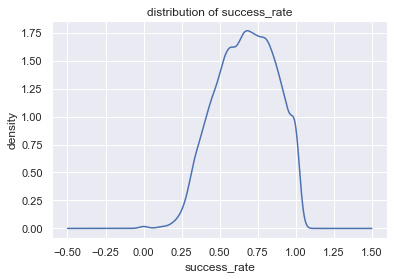

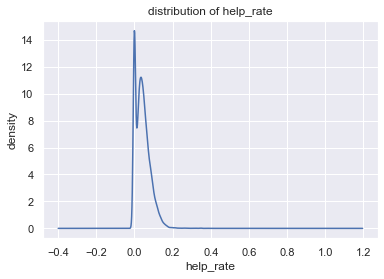

In [960]:
fig = plt.figure()
fig.set(alpha=0.2)
seq_uid_df['success_rate'].plot(kind='kde')    # plots a kernel desnsity estimate of customer 
plt.xlabel(u"success_rate")# plots an axis lable
plt.ylabel(u"density") 
plt.title(u"distribution of success_rate")

fig = plt.figure()
fig.set(alpha=0.2)
seq_uid_df['help_rate'].plot(kind='kde')    # plots a kernel desnsity estimate of customer 
plt.xlabel(u"help_rate")# plots an axis lable
plt.ylabel(u"density") 
plt.title(u"distribution of help_rate")

#### 通过概率密度函数观察特征与label之间的关系   
橘色 - label 1 - 流失  
蓝色 - label 0 - 留下

0    7185
1    3631
Name: label, dtype: int64
1    3631
0    3631
Name: label, dtype: int64


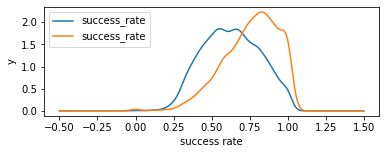

In [221]:
train_df_x['label'] = train_y
dev_df_x['label'] = dev_y
X = train_df_x.append(dev_df_x)
print(X['label'].value_counts())
x0 = X[X['label']==0].sample(n=3631)
x = x0.append(X[X['label']==1])
print(x['label'].value_counts())
  
for i in range(2):
    X['success_rate'][X['label']==i].plot.kde(figsize=(6,2),legend=True)
plt.xlabel('success rate')
plt.ylabel('y')
plt.show()

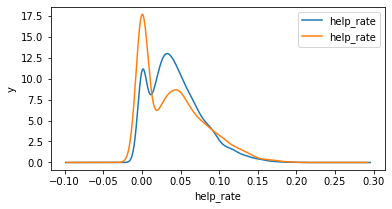

In [109]:
for i in range(2):
    X[(X['label']==i) & (X['help_rate']<0.2) & (X['help_rate']>=0)].help_rate.plot.kde(figsize=(6,3),legend=True)
plt.xlabel('help_rate')
plt.ylabel('y')
plt.show()

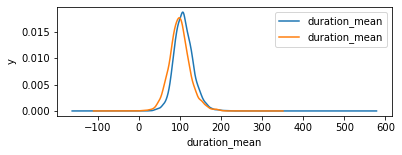

In [110]:
for i in range(2):
    X['duration_mean'][X['label']==i].plot.kde(figsize=(6,2),legend=True)
plt.xlabel('duration_mean')
plt.ylabel('y')
plt.show()

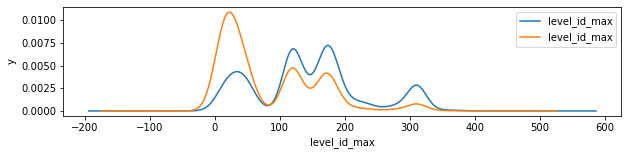

In [111]:
for i in range(2):
    X[(X['level_id_max'] < 400) & (X['label']==i)].level_id_max.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('level_id_max')
plt.ylabel('y')
plt.show()

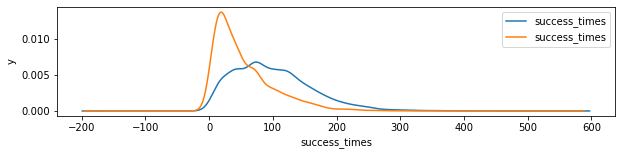

In [112]:
	for i in range(2):
    X[(X['success_times'] < 400) & (X['label']==i)].success_times.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('success_times')
plt.ylabel('y')
plt.show()

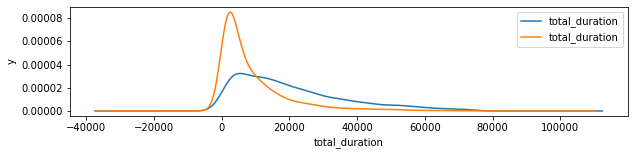

In [113]:
for i in range(2):
    X[(X['label']==i) & (X['total_duration'] < 75000)].total_duration.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('total_duration')
plt.ylabel('y')
plt.show()

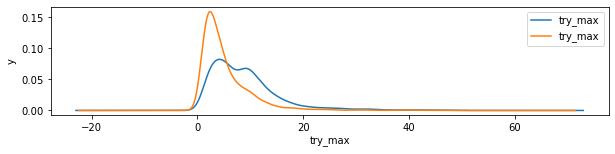

In [114]:
for i in range(2):
    X[(X['label']==i) & (X['try_max']<50)].try_max.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('try_max')
plt.ylabel('y')
plt.show()

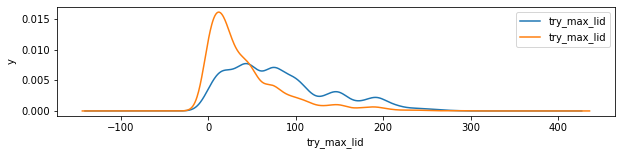

In [115]:
for i in range(2):
    X[(X['label']==i) & (X['try_max_lid']<300)].try_max_lid.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('try_max_lid')
plt.ylabel('y')
plt.show()

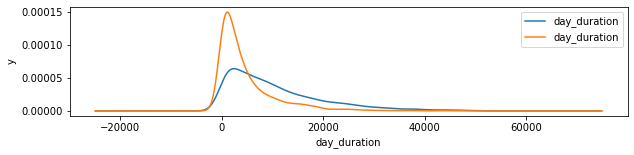

In [116]:
for i in range(2):
    X[(X['label']==i) & (X['day_duration']<50000)].day_duration.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('day_duration')
plt.ylabel('y')
plt.show()

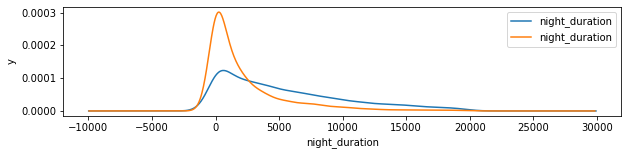

In [117]:
for i in range(2):
    X[(X['label']==i) & (X['night_duration']<20000)].night_duration.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('night_duration')
plt.ylabel('y')
plt.show()

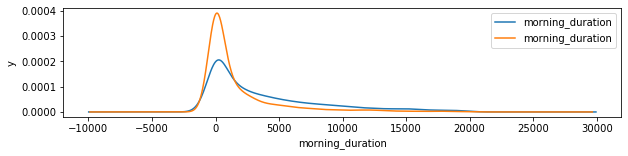

In [118]:
for i in range(2):
    X[(X['label']==i) & (X['morning_duration']<20000)].morning_duration.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('morning_duration')
plt.ylabel('y')
plt.show()

In [ ]:
'''
for i in range(2):
    X[(X['label']==i) & (X['day_count']<500)].day_count.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('day_count')
plt.ylabel('y')
plt.show()
'''

In [ ]:
for i in range(2):
    X[(X['label']==i) & (X['night_count']<300)].night_count.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('night_count')
plt.ylabel('y')
plt.show()

In [ ]:
for i in range(2):
    X[(X['label']==i) & (X['morning_count']<300)].morning_count.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('morning_count')
plt.ylabel('y')
plt.show()

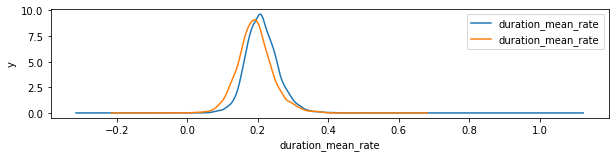

In [120]:
for i in range(2):
    X[(X['label']==i) & (X['duration_mean_rate']<300)].duration_mean_rate.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('duration_mean_rate')
plt.ylabel('y')
plt.show()

4,10,3,0.73414  
4,10,4,0.73192  

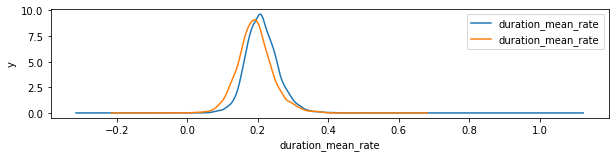

In [121]:
for i in range(2):
    X[(X['label']==i) & (X['reststep_mean']<300)].duration_mean_rate.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('duration_mean_rate')
plt.ylabel('y')
plt.show()

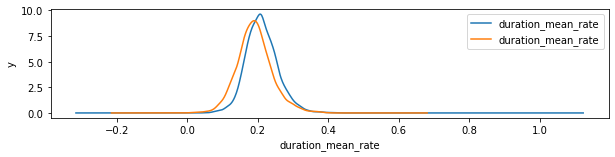

In [123]:
for i in range(2):
    X[(X['label']==i) & (X['shdrl']<300)].duration_mean_rate.plot.kde(figsize=(10,2),legend=True)
plt.xlabel('duration_mean_rate')
plt.ylabel('y')
plt.show()

drop ['night_duration','morning_duration','day_duration','duration_mean_rate','passrate_rate','duration_rate','shdrl'] 0.7346  
0.7346

In [46]:
DT = DecisionTreeClassifier(random_state = 8, min_samples_leaf = 10, max_depth = 3)
DT.fit(train_x, train_y)
pred_train_y = DT.predict(train_x)
pred_dev_y = DT.predict(dev_x)
prob_dev_y = DT.predict_proba(dev_x)
print("the AUC of verify is %.6f" %(roc_auc_score(dev_y, prob_dev_y[:,1])))
print("the accuracy of verify result is %.6f" %(accuracy_score(dev_y, pred_dev_y)))
prob_test_y = DT.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
dt_df = pd.DataFrame(result, columns=['user_id','proba'])
dt_df.to_csv('./result.csv', sep=',', header=True, index=False)

the AUC of verify is 0.750690
the accuracy of verify result is 0.731753


0.73625  
drop ['night_duration','morning_duration','day_duration','duration_mean_rate','passrate_rate','duration_rate','shdrl'] 0.73999  
multi only uid  
0.74208
cut 0.746

In [39]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(train_x, train_y)
pred_dev_y = lr.predict(dev_x)
dev_prob_y = lr.predict_proba(dev_x)
print("the AUC of verify is %.6f" %(roc_auc_score(dev_y, dev_prob_y[:,1])))
print("the accuracy of verify result is %.6f" %(accuracy_score(dev_y, pred_dev_y)))
prob_test_y = lr.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
lr_df = pd.DataFrame(result, columns=['user_id','proba'])
lr_df.to_csv('./result.csv', sep=',', header=True, index=False)

the AUC of verify is 0.752074
the accuracy of verify result is 0.728367


In [ ]:
a = seq_uid_df.columns.tolist()
print(a)
print(type(lr.coef_))
print(lr.coef_.reshape(-1))
sns.set()
sns.barplot(x=lr.coef_.reshape(-1), y=a)
plt.show()

0.67193

In [59]:
BNB = BernoulliNB()
BNB.fit(train_x,train_y)
pred_train_y = BNB.predict(train_x)
pred_dev_y = BNB.predict(dev_x)
prob_y = BNB.predict_proba(dev_x)
verify_acc = accuracy_score(pred_dev_y, dev_y)
train_acc = accuracy_score(pred_train_y, train_y)
print("Accuracy train by BernoulliNB is : %.6f" %(train_acc))
print("Accuracy verify by BernoulliNB is : %.6f" %(verify_acc))
print("The AUC by BernoulliNB of verify is %.6f" %(roc_auc_score(dev_y, prob_y[:,1])))
prob_test_y = BNB.predict_proba(test_x)
prob_train_y = BNB.predict_proba(train_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
bnb_df = pd.DataFrame(result, columns=['user_id','proba'])
bnb_df.to_csv('./result.csv', sep=',', header=True, index=False)
print(prob_train_y)
print(prob_train_y.shape)

Accuracy train by BernoulliNB is : 0.685836
Accuracy verify by BernoulliNB is : 0.679458
The AUC by BernoulliNB of verify is 0.642555
[[0.84585331 0.15414669]
 [0.84585331 0.15414669]
 [0.84585331 0.15414669]
 ...
 [0.14873268 0.85126732]
 [0.0556606  0.9443394 ]
 [0.14873268 0.85126732]]
(10816, 2)


0.70709  
drop ['night_duration','morning_duration','day_duration','duration_mean_rate','passrate_rate','duration_rate','shdrl'] 0.73622  
mult only uid  
0.73663  

In [ ]:
SVM = SVC(probability=True,kernel='linear')
SVM.fit(train_x, train_y)
pred_dev_y = SVM.predict(dev_x)
prob_dev_y = SVM.predict_proba(dev_x)[:,1]
print("the accuracy of train result by svm is %.6f" %(accuracy_score(pred_dev_y, dev_y)))
print("The AUC by svm of verify is %.6f" %(roc_auc_score(dev_y, prob_dev_y)))
prob_test_y = SVM.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
svm_df = pd.DataFrame(result, columns=['user_id','proba'])
svm_df.to_csv('./result.csv', sep=',', header=True, index=False)

b,10,4,1000,0.7432  
u,10,4,1000,0.74255  
b,10,10,1000,0.74392  
b,20,10,1000,0.74393  
b,10,10,100,0.74325  
b,20,10,10000,0.74405  

mult only uid  
0.74711  

drop ['night_duration','morning_duration','day_duration','duration_mean_rate','passrate_rate','duration_rate','shdrl'] 0.74688

In [47]:
tree = DecisionTreeClassifier(random_state=4, class_weight='balanced', max_depth=20, min_samples_leaf = 10)
#tree = DecisionTreeClassifier(random_state=4, max_depth=10, min_samples_leaf = 4)
bagdt = BaggingClassifier(base_estimator=tree, n_estimators=100, max_samples=0.05, bootstrap=True, bootstrap_features=False, random_state=0)
bagdt.fit(train_x, train_y)
pred_y = bagdt.predict(dev_x)
prob_y = bagdt.predict_proba(dev_x)
print(pred_y[0:30])
print("accuracy is %.6f" %(accuracy_score(pred_y, dev_y)))
print('auc is %.6f' %(roc_auc_score(dev_y, prob_y[:,1])))
prob_test_bagdt_y = bagdt.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_bagdt_y[:,1]]).T 
bagdt_df = pd.DataFrame(result, columns=['user_id','proba'])
bagdt_df.to_csv('./result.csv', sep=',', header=True, index=False)

[0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1]
accuracy is 0.724981
auc is 0.769819


In [55]:
SVM = SVC(probability=True, gamma = 'auto',kernel='linear')
#tree = DecisionTreeClassifier(random_state=4, max_depth=10, min_samples_leaf = 4)
bagsvm = BaggingClassifier(base_estimator=SVM, n_estimators=10, max_samples=0.05, bootstrap=True, bootstrap_features=False, random_state=0)
bagsvm.fit(train_x, train_y)
pred_y = bagsvm.predict(dev_x)
prob_y = bagsvm.predict_proba(dev_x)
print(pred_y[0:30])
print("accuracy is %.6f" %(accuracy_score(pred_y, dev_y)))
print('auc is %.6f' %(roc_auc_score(dev_y, prob_y[:,1])))
prob_test_svm_y = bagsvm.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_svm_y[:,1]]).T 
bagsvm_df = pd.DataFrame(result, columns=['user_id','proba'])
bagsvm_df.to_csv('./result.csv', sep=',', header=True, index=False)

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
accuracy is 0.627916
auc is 0.449130


In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10, weights = 'uniform', n_jobs=-1,algorithm='kd_tree')
bagknn = BaggingClassifier(base_estimator=knn, n_estimators=100, max_samples=0.05, bootstrap=True, bootstrap_features=False, random_state=0)
bagknn.fit(train_x, train_y)
pred_y = bagknn.predict(dev_x)
prob_y = bagknn.predict_proba(dev_x)
print(pred_y[0:30])
print("accuracy is %.6f" %(accuracy_score(pred_y, dev_y)))
print('auc is %.6f' %(roc_auc_score(dev_y, prob_y[:,1])))
prob_test_knn_y = bagknn.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_knn_y[:,1]]).T 
bagknn_df = pd.DataFrame(result, columns=['user_id','proba'])
bagknn_df.to_csv('./result.csv', sep=',', header=True, index=False)

[0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
accuracy is 0.729496
auc is 0.753191


In [60]:
BNB = BernoulliNB()
bagbnb = BaggingClassifier(base_estimator=BNB, n_estimators=100, max_samples=0.05, bootstrap=True, bootstrap_features=False, random_state=0)
bagbnb.fit(train_x, train_y)
pred_y = bagbnb.predict(dev_x)
prob_y = bagbnb.predict_proba(dev_x)
print(pred_y[0:30])
print("accuracy is %.6f" %(accuracy_score(pred_y, dev_y)))
print('auc is %.6f' %(roc_auc_score(dev_y, prob_y[:,1])))
prob_test_bnb_y = bagbnb.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_bnb_y[:,1]]).T 
bagbnb_df = pd.DataFrame(result, columns=['user_id','proba'])
bagbnb_df.to_csv('./result.csv', sep=',', header=True, index=False)

[0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
accuracy is 0.679458
auc is 0.642555


In [ ]:
lr = LogisticRegression()
bagbnb = BaggingClassifier(base_estimator=lr, n_estimators=1, max_samples=0.05, bootstrap=True, bootstrap_features=False, random_state=0)
bagbnb.fit(train_x, train_y)
pred_y = bagbnb.predict(dev_x)
prob_y = bagbnb.predict_proba(dev_x)
print(pred_y[0:30])
print("accuracy is %.6f" %(accuracy_score(pred_y, dev_y)))
print('auc is %.6f' %(roc_auc_score(dev_y, prob_y[:,1])))
prob_test_bnb_y = bagbnb.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_bnb_y[:,1]]).T 
bagbnb_df = pd.DataFrame(result, columns=['user_id','proba'])
bagbnb_df.to_csv('./result.csv', sep=',', header=True, index=False)

10,30,1000,0.70107  
10,10,1000,0.7045  
10,10,100,0.72989    
10,10,120,0.72045  
10,20,100,0.72576  
20,10,100,0.73038  
30,10,100,0.72968  

mult only uid  
0.73424  
drop ['night_duration','morning_duration','day_duration','duration_mean_rate','passrate_rate','duration_rate','shdrl']  0.73029

In [22]:
tree = DecisionTreeClassifier(random_state = 4, max_depth = 20, min_samples_leaf = 10)
adadt = AdaBoostClassifier(base_estimator=tree, n_estimators=100, learning_rate=0.01)
adadt.fit(train_x, train_y)
pred_y = adadt.predict(dev_x)
prob_y = adadt.predict_proba(dev_x)
print(pred_y[0:30])
print("accuracy is %.6f" %(accuracy_score(pred_y, dev_y)))
auc = roc_auc_score(dev_y, prob_y[:,1])
print('auc is %.6f' %(auc))
prob_test_y = adadt.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
adadt_df = pd.DataFrame(result, columns=['user_id','proba'])
adadt_df.to_csv('./result.csv', sep=',', header=True, index=False)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
accuracy is 0.661023
auc is 0.402371


GDBT + lr  
50-50  
20,0.73329  
100,0.71753  
10,0.73766  
5,0.74171  
3,0.7378  
5,10,5,0.73244  
5,5,5,0.72989  
5,20,5,0.72907  
5,3,5,0.73455  
5,3,3,0.74064  
5,1,3,0.73537  

multi only uid  
0.74263  
0.74358  same drop  


In [250]:
X_train, X_verify, y_train, y_verify = train_test_split(train_x, train_y, test_size=0.5)
print(X_train.shape, X_verify.shape, y_train.shape, y_verify.shape)
print(train_x.shape)

gdbt = GradientBoostingClassifier( n_estimators=5 ,min_samples_leaf=3, max_depth=3)
gdbt.fit(X_train, y_train)
#gdbt.fit(train_x, train_y)
#temp = gdbt.apply(X_train)
#print(temp)
gdbt_enc = OneHotEncoder(categories='auto')
#gdbt_enc.fit(gdbt.apply(train_x)[:,:,0])
gdbt_enc.fit(gdbt.apply(X_train)[:,:,0])
LR = LogisticRegression( max_iter=1000,penalty='l2')
#LR.fit(gdbt_enc.transform(gdbt.apply(train_x)[:,:,0]),train_y)
LR.fit(gdbt_enc.transform(gdbt.apply(X_verify)[:,:,0]),y_verify)
#prob_y = LR.predict_proba(gdbt_enc.transform(gdbt.apply(X_verify)[:,:,0]))
prob_y = LR.predict_proba(gdbt_enc.transform(gdbt.apply(X_verify)[:,:,0]))
print("the AUC of verify by gdbt + lr is %.6f" %(roc_auc_score(y_verify, prob_y[:,1])))

dev_prob_y = LR.predict_proba(gdbt_enc.transform(gdbt.apply(dev_x)[:,:,0]))
print("the AUC of dev by gdbt + lr is %.6f" %(roc_auc_score(dev_y, dev_prob_y[:,1])))
prob_test_y = LR.predict_proba(gdbt_enc.transform(gdbt.apply(test_x)[:,:,0]))
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
gdbtlr_df = pd.DataFrame(result, columns=['user_id','proba'])
gdbtlr_df.to_csv('./result.csv', sep=',', header=True, index=False)

(5408, 29) (5408, 29) (5408,) (5408,)
(10816, 29)
the AUC of verify by gdbt + lr is 0.748131
the AUC of dev by gdbt + lr is 0.755407


gdbt  
20,0.74425  
5,0.74123  
10,0.74327  
30,0.74458  
40,0.74457  
20,0.74425  

multi only uid  
0.74588  
drop ['night_duration','morning_duration','day_duration','duration_mean_rate','passrate_rate','duration_rate','shdrl'] 0.74433  

In [43]:
gdbt = GradientBoostingClassifier(n_estimators=20,min_samples_leaf=3,max_depth=3)
gdbt.fit(train_x, train_y)
dev_prob_y = gdbt.predict_proba(dev_x)
print('the AUC of the dev by gdbt is %.6f ' %(roc_auc_score(dev_y, dev_prob_y[:,1])))
prob_test_y = gdbt.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
gdbt1_df = pd.DataFrame(result, columns=['user_id','proba'])
gdbt1_df.to_csv('./result.csv', sep=',', header=True, index=False)

the AUC of the dev by gdbt is 0.756580 


xgboost  
0.7381  

multi only uid  
0.74563  
drop ['night_duration','morning_duration','day_duration','duration_mean_rate','passrate_rate','duration_rate','shdrl']  0.74534  

d1234 0.74714


In [23]:
#xgb = XGBClassifier(learning_rate=0.1, class_weight='balanced', max_depth=9, min_child_weight=6, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)
xgb = XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=6, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)
xgb.fit(train_x, train_y)
dev_prob_y = xgb.predict_proba(dev_x)
print('the AUC of the dev by xgboost is %.6f ' %(roc_auc_score(dev_y, dev_prob_y[:,1])))
prob_test_y = xgb.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
xgb_df = pd.DataFrame(result, columns=['user_id','proba'])
xgb_df.to_csv('./result.csv', sep=',', header=True, index=False)

the AUC of the dev by xgboost is 0.733143 


In [24]:
xgb = XGBClassifier( learning_rate=0.01, max_depth=7, min_child_weight=19, n_estimators=100, n_jobs=1, subsample=0.1, verbosity=0)
xgb.fit(train_x, train_y)
dev_prob_y = xgb.predict_proba(dev_x)
print('the AUC of the dev by xgboost is %.6f ' %(roc_auc_score(dev_y, dev_prob_y[:,1])))
prob_test_y = xgb.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
xgb_df = pd.DataFrame(result, columns=['user_id','proba'])
xgb_df.to_csv('./result.csv', sep=',', header=True, index=False)

the AUC of the dev by xgboost is 0.743949 


lightgbm  
0.74196  

multi only uid  
0.74513  

d1234 0.74414

In [25]:
lgb_train = lgb.Dataset(train_x, train_y)
param = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'num_leaves':30, 
    'num_trees': 300,
    'objective':'binary',
    'max_depth':3,
    'max_bin':40,
    'learning_rate': 0.01,
	'feature_fraction': 0.6,
	'bagging_fraction': 1,
    'is_unbalance':True,
	'bagging_freq': 20,
	'verbose': 0
}
param['metric'] = ['auc']

gbm = lgb.train(param,lgb_train)
dev_ligbm_y = gbm.predict(dev_x)
print(dev_ligbm_y.shape)
print('the AUC of the dev by lgb is %.6f ' %(roc_auc_score(dev_y, dev_ligbm_y)))
test_ligbm_y = gbm.predict(test_x)
result = np.vstack([test_df.user_id.values, test_ligbm_y]).T 
gbm_df = pd.DataFrame(result, columns=['user_id','proba'])
gbm_df.to_csv('./result.csv', sep=',', header=True, index=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
(2658,)
the AUC of the dev by lgb is 0.682799 


tpot  

In [984]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, scoring='roc_auc', cv=5, random_state=42, verbosity=2)

pipeline_optimizer.fit(train_x, train_y)

print(pipeline_optimizer.score(dev_x, dev_y))

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.753309193779746

Generation 2 - Current best internal CV score: 0.7533792250234324

Generation 3 - Current best internal CV score: 0.7535360616887666

Generation 4 - Current best internal CV score: 0.7535360616887666

Generation 5 - Current best internal CV score: 0.7535360616887666

Best pipeline: XGBClassifier(VarianceThreshold(input_matrix, threshold=0.001), learning_rate=0.01, max_depth=7, min_child_weight=19, n_estimators=100, n_jobs=1, subsample=0.1, verbosity=0)
0.7600427527246334


In [28]:
# 0.74292
#0.74793
# d1234 0.74499
gdbt = GradientBoostingClassifier(random_state=8, learning_rate=0.01, max_depth=4, max_features=0.15000000000000002, min_samples_leaf=13, min_samples_split=15, n_estimators=100, subsample=0.2)
gdbt.fit(train_x, train_y)
dev_prob_y = gdbt.predict_proba(dev_x)
print('the AUC of the dev by gdbt is %.6f ' %(roc_auc_score(dev_y, dev_prob_y[:,1])))
prob_test_y = gdbt.predict_proba(test_x)
result = np.vstack([test_df.user_id.values, prob_test_y[:,1]]).T 
gdbt2_df = pd.DataFrame(result, columns=['user_id','proba'])
gdbt2_df.to_csv('./result.csv', sep=',', header=True, index=False)

the AUC of the dev by gdbt is 0.742562 


融合

In [260]:
gbdt1 = 1
gbdt2 = 1.1
gbm=1
gdbtlr=1
dt=1
lr=1
xgb=1.4
adadt=1
bagdt=1
ws = [gdbt, gbm, gdbtlr, dt, lr, bagdt]
dfs = [gdbt_df, gbm_df, gdbtlr_df, dt_df, lr_df, bagdt_df]
#ws = [gdbt, bagdt]
#dfs = [gdbt_df, xgb_df] #0.74794 mult only uid
# gdbt, xgb, lr 0.74822 
# gdbt, xgb, lr, gbm 0.7483
#gdbt, xgb, lr, gbm, gdbtlr 0.74837
ws = [gbdt1, gbdt2, xgb, gbm]
dfs = [gdbt1_df, gdbt2_df, xgb_df, gbm_df]
ws = [xgb, gbm]
dfs = [xgb_df, gbm_df]
#print(ws, dfs)
dfs = np.array(dfs)
print(dfs.shape)
def weight(ws,dfs):
    ws = np.array(ws)
    dfs = np.array(dfs)
    #print(dfs.shape)
    #print(dfs)
    print(len(ws))
    print((dfs[:,:,1].T*ws).shape)
    Sum = (dfs[:,:,1].T*ws).T.sum(axis=0)/len(ws)
    print(Sum.shape)
    #print(Sum)
    return Sum

w = weight(ws,dfs)
result = np.vstack([test_df.user_id.values, w]).T 
weight_df = pd.DataFrame(result, columns=['user_id','proba'])
weight_df.to_csv('./result.csv', sep=',', header=True, index=False)

(2, 2773, 2)
2
(2773, 2)
(2773,)


In [1193]:
from tensorflow import keras
train_x.shape, train_y.shape

((10816, 185), (10816,))

In [1195]:
model = keras.Sequential([
    keras.layers.Dense(300, activation='relu', input_shape=[185,]),
    keras.layers.Dense(300, activation='relu' ),
    keras.layers.Dense(300, activation='relu' ),
    keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['AUC'])
model.fit(train_x, train_y, batch_size=1024, epochs=100)

Epoch 1/100
11/11 [==============================] - 2s 22ms/step - loss: 0.6418 - auc: 0.5524
Epoch 2/100
11/11 [==============================] - 0s 34ms/step - loss: 0.5565 - auc: 0.7436
Epoch 3/100
11/11 [==============================] - 0s 30ms/step - loss: 0.5541 - auc: 0.7468
Epoch 4/100
11/11 [==============================] - 0s 24ms/step - loss: 0.5452 - auc: 0.7544
Epoch 5/100
11/11 [==============================] - 0s 28ms/step - loss: 0.5487 - auc: 0.7517
Epoch 6/100
11/11 [==============================] - 0s 32ms/step - loss: 0.5484 - auc: 0.7569
Epoch 7/100
11/11 [==============================] - 0s 27ms/step - loss: 0.5399 - auc: 0.7600
Epoch 8/100
11/11 [==============================] - 0s 29ms/step - loss: 0.5352 - auc: 0.7649
Epoch 9/100
11/11 [==============================] - 0s 37ms/step - loss: 0.5377 - auc: 0.7678
Epoch 10/100
11/11 [==============================] - 0s 29ms/step - loss: 0.5289 - auc: 0.7753
Epoch 11/100
11/11 [=============================

In [1200]:
model_y = model.predict(test_x)
print(model_y.reshape(-1).shape)
result = np.vstack([test_df.user_id.values, model_y.reshape(-1)]).T
#result = np.vstack([test_df.Id.values, model_y.reshape(-1)]).T 
deep_df = pd.DataFrame(result, columns=['user_id','proba'])
deep_df.to_csv('./result.csv', sep=',', header=True, index=False)

(2773,)


### level_meta.csv
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [263]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df 

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


发现成功率最低是0，进而发现983和1015关卡是没有人能通过的，并且只有用户434玩过，但是后面的关卡有数据，说明关卡升级并非必须通关。

In [264]:
meta_df.describe()

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000
mean,514.408527,0.445386,116.009104,3.421754,755.000000
std,234.731711,0.190031,27.655346,4.068877,435.755092
min,39.889940,0.000000,35.582757,0.000000,1.000000
25%,372.250000,0.334503,101.239606,2.000000,378.000000
50%,497.652174,0.402935,112.666667,3.291613,755.000000
75%,623.587065,0.509404,126.443548,4.406417,1132.000000
max,2105.000000,1.000000,540.000000,98.000000,1509.000000


Text(0.5, 1.0, 'distribution of win_duration')

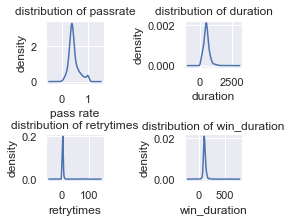

In [265]:
fig = plt.figure()
fig.set(alpha=0.2)

plt.subplot2grid((3,5),(0,0)) 
meta_df['f_avg_passrate'].plot(kind='kde')    # plots a kernel desnsity estimate of customer 
plt.xlabel(u"pass rate")# plots an axis lable
plt.ylabel(u"density") 
plt.title(u"distribution of passrate")

plt.subplot2grid((4,5),(0,2))   
meta_df['f_avg_duration'].plot(kind='kde')    # plots a kernel desnsity estimate of customer 
plt.xlabel(u"duration")# plots an axis lable
plt.ylabel(u"density") 
plt.title(u"distribution of duration")

plt.subplot2grid((4,5),(2,0))   
meta_df['f_avg_retrytimes'].plot(kind='kde')    # plots a kernel desnsity estimate of customer 
plt.xlabel(u"retrytimes")# plots an axis lable
plt.ylabel(u"density") 
plt.title(u"distribution of retrytimes")

plt.subplot2grid((4,5),(2,2))   
meta_df['f_avg_win_duration'].plot(kind='kde')    # plots a kernel desnsity estimate of customer 
plt.xlabel(u"win_duration")# plots an axis lable
plt.ylabel(u"density") 
plt.title(u"distribution of win_duration")

In [21]:
meta_df[meta_df['f_avg_passrate']==0]

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
982,1128.0,0.0,540.0,98.0,983
1014,1091.0,0.0,540.0,98.0,1015


In [35]:
seq_df[(seq_df['level_id']==983) | (seq_df['level_id']==1015)]

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day,night
380408,434,983,0,122.0,0.0,0,2020-02-01 21:24:17,False,True
380409,434,983,0,114.0,0.0,0,2020-02-01 21:26:18,False,True
380410,434,983,0,119.0,0.0,0,2020-02-01 21:28:19,False,True
380411,434,983,0,88.0,0.0,0,2020-02-01 21:29:48,False,True
380412,434,983,0,131.0,0.0,0,2020-02-01 21:34:57,False,True
380413,434,983,0,105.0,0.0,0,2020-02-01 21:38:56,False,True
380414,434,983,0,91.0,0.0,0,2020-02-01 21:40:28,False,True
380415,434,983,0,103.0,0.0,0,2020-02-01 21:44:06,False,True
380416,434,983,0,163.0,0.0,1,2020-02-01 21:46:51,False,True
380417,434,983,0,92.0,0.0,0,2020-02-01 21:48:27,False,True


In [34]:
seq_df[seq_df['level_id'] > 983]

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day,night
380418,434,984,0,98.0,0.000000,0,2020-02-01 21:54:24,False,True
380419,434,984,0,126.0,0.000000,0,2020-02-01 22:00:43,False,True
380420,434,984,0,140.0,0.000000,0,2020-02-01 22:03:05,False,True
380421,434,984,0,128.0,0.000000,0,2020-02-01 22:05:15,False,True
380422,434,984,0,134.0,0.000000,0,2020-02-01 22:07:32,False,True
...,...,...,...,...,...,...,...,...,...
2177118,10861,1508,0,85.0,0.000000,0,2020-02-03 15:38:47,True,False
2177119,10861,1508,1,97.0,0.115385,0,2020-02-03 15:40:25,True,False
2177120,10861,1509,0,86.0,0.000000,0,2020-02-03 15:42:01,True,False
2177121,10861,1509,0,193.0,0.000000,0,2020-02-03 15:45:13,True,False


## 四、Tips

* 一个基本的思路可以是：根据游玩关卡的记录为每个用户提取特征 → 结合 label 构建表格式的数据集 → 使用不同模型训练与测试；
* 还可以借助其他模型（如循环神经网络）直接对用户历史序列建模；
* 数据量太大运行时间过长的话，可以先在一个采样的小训练集上调参；
* 集成多种模型往往能达到更优的效果；
* 可以使用各种开源工具。